# Projet Statistique en Grande Dimension
<b>Groupe </b>: Laurène DAVID, Safa HAMDAN, Allan PENDANT <br>
M2 TIDE 2021-2022

# Introduction
Dans ce projet, nous allons présenter et implémenter en python les méthodes de <b>sélection de variables</b> (et de réduction de dimension), de <b>clustering</b> et de <b>prédiction</b> vues pendant le cours de Statistique en Grande Dimension. <br>

Pour illuster ces modèles, nous utiliserons deux jeux de données <i>winequality_white</i> et <i>winequality_red</i> sur des vins rouges et blanc et des jeux de données sur le <i>titanic</i>. Avant de construire nos modèles, nous allons faire une première analyse descriptive de nos données pour détecter de possible variables manquantes ou données extrêmes.
<br>
<br>

Nous allons d'abord importer les libraires python et les jeu données qui vont nous servir pour le projet.

In [1]:
#librairies python
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import networkx as nx

#style des graphs matplotlib et sns
sns.set_style("whitegrid")

In [2]:
#enlever écriture scientific dans les np.array
np.set_printoptions(suppress=True)

In [3]:
#Importation dataset "titanic"
titanic = pd.read_csv("titanic.csv")
t_train = pd.read_csv("train-data.csv")
t_test = pd.read_csv("test-data.csv")

#Importation des deux jeux de données "winequality"
wine_red = pd.read_csv("winequality-red.csv", sep=';')
wine_white = pd.read_csv("winequality-white.csv", sep=';')

# Préparation des données

Avant de présenter les différentes méthodes de sélection de variable/réduction de dimension, nous allons analyser les jeux de données sur le vin. <br>

Nous allons d'abord construire une nouvelle variable sur le jeu de données du vin rouge pour indiquer le type de vin (qui nous servira lorsque l'on va concaténer les deux jeu de données du vin).

In [4]:
wine_red['type'] = [1]*wine_red.shape[0]

<br>
Nous allons maintenant construire un boxplot pour chaque variable du dataset pour détecter la présence de valeurs extrèmes.

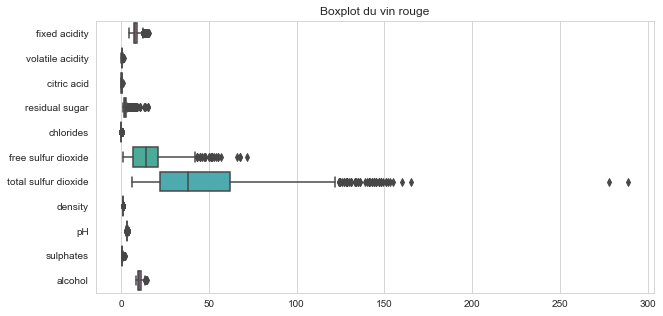

In [5]:
melt_red = wine_red.drop(columns = ['quality', 'type']).melt(value_vars=wine_red.drop(columns = ['quality', 'type']).columns)

plt.figure(figsize = (10,5));
sns.boxplot(x = 'value', y = 'variable', data = melt_red);
plt.title('Boxplot du vin rouge');
plt.ylabel('');
plt.xlabel('');

La plupart des variables possèdent un grand nombre de valeur extrêmes. <br>
Nous allons donc supprimer ces valeurs dans notre dataset.

In [6]:
#lignes avec valeurs extremes
var_1 = wine_red['total sulfur dioxide'].sort_values().tail(30).index.tolist()
var_2 = wine_red['free sulfur dioxide'].sort_values().tail(30).index.tolist()
var_3 = wine_red['residual sugar'].sort_values().tail(30).index.tolist()
var_4 = wine_red['fixed acidity'].sort_values().tail(30).index.tolist()

index_remove = var_1 + var_2 + var_3 + var_4

#dataset wine_red sans valeurs extremes
wine_red.drop(index_remove, axis=0, inplace = True)

<br>
Nous allons faire la même chose avec le dataset sur le <b>vin blanc</b>.

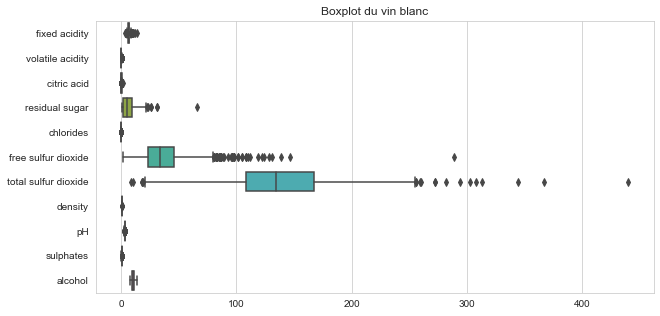

In [7]:
wine_white['type'] = [0]*wine_white.shape[0]
melt_white = wine_white.drop(columns = ['quality', 'type']).melt(value_vars=wine_white.drop(columns = ['quality', 'type']).columns)

plt.figure(figsize = (10,5));
sns.boxplot(x = 'value', y = 'variable', data = melt_white);
plt.title('Boxplot du vin blanc');
plt.ylabel('');
plt.xlabel('');

In [8]:
#lignes avec valeurs extremes
var_1 = wine_white['total sulfur dioxide'].sort_values().tail(10).index.tolist()
var_2 = wine_white['free sulfur dioxide'].sort_values().tail(30).index.tolist()
var_3 = wine_white['residual sugar'].sort_values().tail(10).index.tolist()
var_4 = wine_white['fixed acidity'].sort_values().tail(35).index.tolist()
index_remove_2 = var_1 + var_2 + var_3 + var_4

wine_white.drop(index_remove_2, axis=0, inplace = True)

<br>
Nous allons maintenant fusionner les deux jeux de données pour construire un dataset <i>wine</i>

In [9]:
#fusion des deux datasets
wine = pd.concat([wine_red, wine_white], axis = 0)
wine = wine.sample(frac=1).reset_index(drop=True)

# Sélection de Variable et Réduction de dimension (Par Laurène David)

## Principal Component Analysis (ACP)

L'<b> ACP </b> est une méthode de réduction de dimension qui consiste à retrouver les meilleures approximations linéaires de nos données, appelées composantes principales. <br>
Pour retrouver ces composantes principales, l'ACP détermine les directions orthogonales qui induisent la plus forte variance des données, le but étant de réduire la dimension de nos données sans perte majeur d'information. <br>

Avant de procéder à une ACP sur nos covariables quantitatives, nous devons d'abord <b>standardiser</b> nos données puisque l'ACP est sensible à la variance des données.

<b> Standardisation des données : </b> <br>
Pour illuster l'ACP, nous allons utiliser les datasets sur le vin rouge et le vin blanc, concaténés en un seul dataframe.

In [10]:
acp_data = wine.drop(columns = ["quality","type"]) #standardiser les variables quantitatives
d = acp_data.shape[1]

Pour standardiser nos données, nous allons utiliser la fonction <b> StandardScaler </b> de scikitlearn qui permet de centrer et de réduire nos données avant d'appliquer une ACP.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(acp_data)
scaler.transform(acp_data, copy = False)[0]

array([ 1.70319734, -0.35174232,  0.64951832, -0.94795442, -0.38863992,
       -0.96868619, -1.01034134, -0.83304111, -1.62810933, -1.90081507,
       -0.00086655])

Le principe de l'ACP est de déterminer les meilleures approximations linéaires de nos données afin de projeter l'ensemble de nos observations sur un espace de dimension réduit, sans perte majeur d'information.

Ces approximations linéaires sont construits à partir des composantes principales de $X$, qui correspondent à l'ensemble des directions orthogonales à forte variance de notre espace.

<b> Composantes principales: </b> <br>
La première étape est de déterminer les composantes principales de $ X $ par une SVD. <br>
La SVD permet de décomposer la matrice de variance-covariance en un produit de matrice $ X = \hat{U}.\hat{D}.\hat{U}^T$ avec $U$ une matrice orthogonale. <br>
Les composantes principales correspondent aux vecteurs colonnes $\hat{U}_j$ de la matrice $\hat{U}$ et sont classées en fonction de leur importance (pour expliquer la variance des données).

In [12]:
from sklearn.decomposition import PCA 
pca = PCA()
pca_fit = pca.fit(acp_data)

pca_fit.components_[0:3]

array([[ 0.21892351,  0.37465203, -0.1734935 , -0.36459933,  0.26958351,
        -0.43979173, -0.48545746,  0.01230686,  0.23054991,  0.27880897,
         0.12599819],
       [ 0.3394529 ,  0.13556225,  0.15442703,  0.30601029,  0.33276961,
         0.05286418,  0.06102105,  0.5898868 , -0.12696476,  0.20834854,
        -0.47345031],
       [ 0.44451982, -0.30324844,  0.59559313, -0.16509427,  0.01831264,
        -0.11832767, -0.10860068, -0.17146767, -0.45031001,  0.08654102,
         0.25030923]])

Nous avons obtenu les $d$ composantes principales de notre dataset "acp_data" grâce à une SVD.  <br>

<br>
<b> Visualisation des données par ACP : </b>  <br>
Nous allons choisir de projeter nos données selon les 2 premières composantes principales de $X$ pour donner une représentation visuelle de l'ACP.

In [13]:
pca_dim2 = PCA(n_components = 2).fit(acp_data[['fixed acidity', 'pH']])
pca_dim2.components_

array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678]])

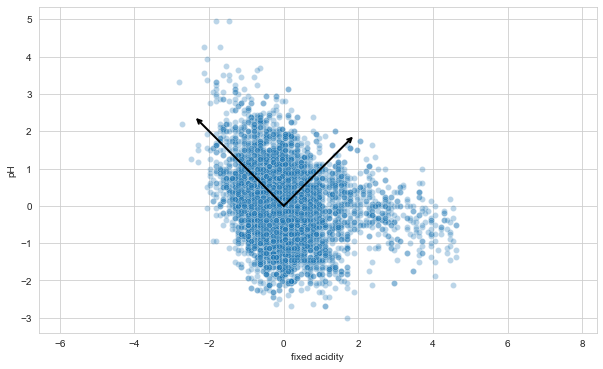

In [14]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.figure(figsize = (10,6));
sns.scatterplot(data = acp_data[['fixed acidity', 'pH']], x = "fixed acidity", y = "pH", alpha = 0.3);
for length, vector in zip(pca_dim2.explained_variance_, pca_dim2.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca_dim2.mean_, pca_dim2.mean_ + v)
plt.axis('equal');

Les deux flèches noires correspond aux directions orthogonales ayant la plus forte dispersion des données. <br>
Ces deux vecteurs orthogonaux vont permettre de construire les 2 composantes principales de nos données.

<br>
<b> Choix des $r$ composantes principales pour projeter nos données </b> : <br>
Nous allons maintenant chercher à determiner le nombre $r$ de composantes principales à sélectionner <br>
Puisque nous cherchons à réduire la dimension $d$ des covariables, nous souhaitons sélectionner $r<d$ composantes qui permettent de maintenir au mieux la variance de nos données. <br>
L'existance de ces $r$ composantes principales part d'une hypothèse de "sparcity" sur l'ensemble des valeurs singulières de $X$ qui stipule que seul les $r$ premières valeurs singulières sont réellement non nulles.

Pour choisir $r$, nous allons utiliser le <i> explained_variance_ratio </i> qui correspond à la part de la variance expliquée par chaque composante.

In [15]:
print("Ratio de la variance expliquée:")
print(pca_fit.explained_variance_ratio_)

Ratio de la variance expliquée:
[0.28384184 0.22650087 0.13938958 0.08734896 0.06437541 0.05445916
 0.0468919  0.04363839 0.03028178 0.02056519 0.0027069 ]


<br>
Nous allons maintenant tracer le ratio cumulée de la variance expliquée.

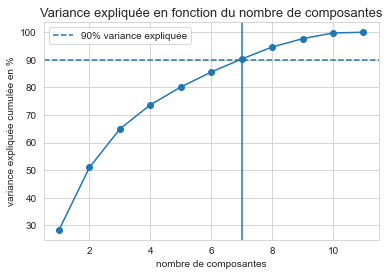

In [16]:
number_comp = np.arange(1, d+1) 
explained_var = pd.DataFrame(np.cumsum(pca_fit.explained_variance_ratio_), columns = ["value"])
explained_var.index = number_comp

plt.plot(number_comp,explained_var["value"]*100, color = 'tab:blue')
plt.scatter(number_comp,explained_var["value"]*100, color = 'tab:blue')
plt.axhline(90, label ='90% variance expliquée', linestyle='--' )
plt.axvline(7)

plt.xlabel('nombre de composantes')
plt.ylabel('variance expliquée cumulée en %');
plt.legend()
plt.title('Variance expliquée en fonction du nombre de composantes', fontsize = 13);

Nous fixons à 90% la part de la variance que doit contenir les $r$ composantes principales. <br>
Nous pouvons voir graphiquement que pour garder 90% de la variance de nos données, nous devons garder les <b>7 premières composantes principales</b>. <br>
Nous allons maintenant vérifier ce nombre en réappliquant une ACP sur nos données, en fixant <i>n_components</i> à 0.9.

In [17]:
pca_r = PCA(n_components=0.90).fit(acp_data)

print(f"Nombre de composantes: {pca_r.n_components_}")
print("")
print(f"Valeurs singulières des composantes :")
print(pca_r.singular_values_)
print("")
print("Composante principale 1 :")
print(pca_r.components_[0])
print("")
print("Composante principale 2 :")
print(pca_r.components_[1])
print("")
print("Composante principale 3 :")
print(pca_r.components_[2])
print("")
print("Composante principale 4 :")
print(pca_r.components_[3])
print("")
print("Composante principale 5 :")
print(pca_r.components_[4])
print("")
print("Composante principale 6 :")
print(pca_r.components_[5])
print("")
print("Composante principale 7 :")
print(pca_r.components_[6])


Nombre de composantes: 7

Valeurs singulières des composantes :
[140.36189809 125.38510958  98.36173573  77.86456974  66.84532093
  61.48178892  57.05056542]

Composante principale 1 :
[ 0.21892351  0.37465203 -0.1734935  -0.36459933  0.26958351 -0.43979173
 -0.48545746  0.01230686  0.23054991  0.27880897  0.12599819]

Composante principale 2 :
[ 0.3394529   0.13556225  0.15442703  0.30601029  0.33276961  0.05286418
  0.06102105  0.5898868  -0.12696476  0.20834854 -0.47345031]

Composante principale 3 :
[ 0.44451982 -0.30324844  0.59559313 -0.16509427  0.01831264 -0.11832767
 -0.10860068 -0.17146767 -0.45031001  0.08654102  0.25030923]

Composante principale 4 :
[-0.19542274 -0.22521166  0.27395857 -0.14214613  0.22129974  0.31460398
  0.19356355 -0.05429934  0.45332627  0.6415876   0.10162183]

Composante principale 5 :
[-0.22299786  0.13573793 -0.13302618 -0.30300102  0.66866617  0.19819964
  0.15961294 -0.301607   -0.43027029 -0.10376357 -0.15362801]

Composante principale 6 :
[ 0.1


<b> Projection des données par ACP : </b>    
Nous allons maintenant représenter les composantes principales sur un plan bidimensionnel et tridimensionel.

In [18]:
projected_data = pd.DataFrame(pca_r.fit_transform(acp_data))
projected_data.columns = ["composante " + str(i) for i in range(1,projected_data.shape[1]+1)]
projected_data['target'] = wine['type']
projected_data.head(5)

,composante 1,composante 2,composante 3,composante 4,composante 5,composante 6,composante 7,target
0,0.370066,-0.581806,2.335628,-2.439720,0.309293,-0.858087,-0.355341,0
1,0.629076,-0.261041,-0.116129,-0.928625,0.488295,0.677129,0.138251,0
2,-0.529664,0.119407,-0.302200,0.463823,-0.885075,-1.275327,0.409487,0
3,-1.554544,0.433194,-0.325739,-0.680894,-0.183008,-1.155549,0.117869,0
4,-0.365553,-1.254013,1.477939,1.689526,0.648386,0.387146,0.938589,0


<b> Visualisation en 2D </b> :

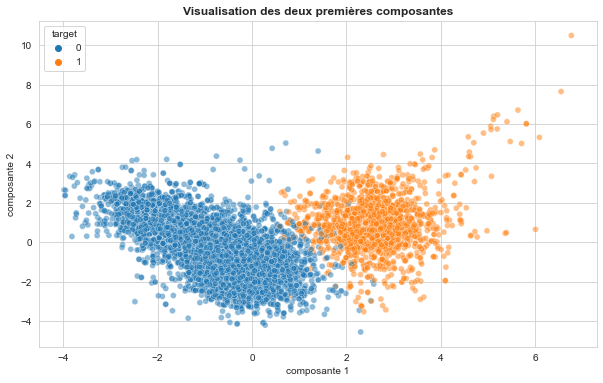

In [19]:
plt.figure(figsize = (10,6));
sns.scatterplot(x = projected_data.iloc[:, 0], 
                y = projected_data.iloc[:, 1], 
                hue=projected_data['target'], 
                alpha=0.5);

plt.title("Visualisation des deux premières composantes", fontweight = 'bold');
plt.xlabel('composante 1');
plt.ylabel('composante 2');

<b> Visualisation en 3D </b> : <br>

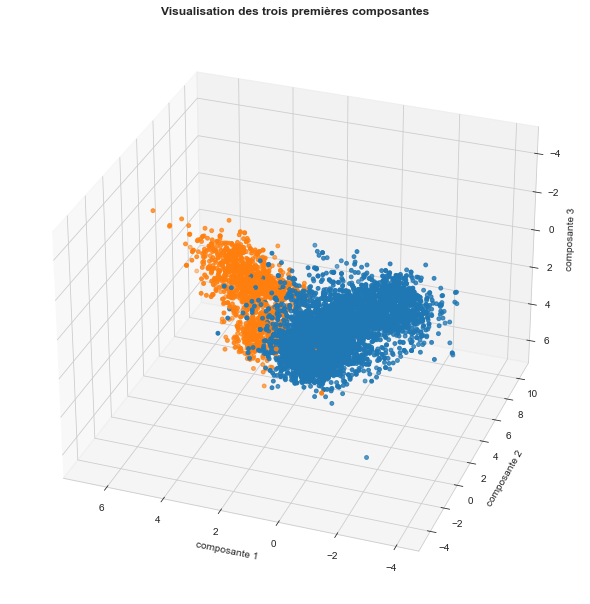

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))

ax = Axes3D(fig, auto_add_to_figure=False) 
fig.add_axes(ax) #rajouter au code existant

x = projected_data.iloc[:, 0]
y = projected_data.iloc[:, 1]
z = projected_data.iloc[:, 2]

colormap = np.array(['tab:blue', 'tab:orange'])

ax.scatter(x, y, z, c=colormap[projected_data['target']], s = 15)
ax.set_xlabel('composante 1')
ax.set_ylabel('composante 2')
ax.set_zlabel('composante 3')
ax.view_init(-150, 70)

plt.title("Visualisation des trois premières composantes", fontweight = 'bold')
plt.show()

print("")
print("")

## Non negative matrix factorization (NMF)

La <b> non negative matrix factorization (NMF)</b> est une variante de l'ACP qui ajoute une contrainte de positivité sur les coefficients des matrices du modèle.    
La NMF réduit la dimension $d$ des covariables en construisant un dictionnaire de $r$ topics qui correspondent à des meta-covariables. Les $n$ observations deviennent alors des combinaisons linéaires des $r$ meta-descriptors à coefficients positifs.

Le but de la NMF est d'approcher la matrice de design $X$ de taille $n \times p$ par le produit d'une matrice $\tilde{X}$ avec la matrice $V$ :

$$X \approx \tilde{X} \times V $$

avec $\tilde{X}$ une matrice de taille $n \times r$
et $V$ une matrice de dimension de taille $r \times p$


Pour illuster la NMF, nous allons utiliser le même jeu de données que pour l'ACP mais sans les standardiser car cela fait apparaître des valeurs négatives.

In [21]:
#Données pour le modèle
nmf_data = wine.drop(columns = ["quality", "type"])

#dimension de l'espace des covariables 
d = nmf_data.shape[1]

Nous allons chercher à déterminer le nombre $r$ de topics à choisir par la méthode du coude. <br>
Nous allons aussi comparer la performance de la NMF avec deux méthodes d'initialisation de l'algorithme d'optimisation, la première étant la méthode "random" et la deuxième étant la "nndsvd".


<b> Choix du nombre $r$ de topics et du paramètre d'initialisation: </b>    
Pour choisir ces deux paramètres, nous allons estimer l'erreur de reconstruction pour chacune des valeurs de nos deux paramètres.    
Le but est de choisir les deux paramètres qui minimise cet erreur.

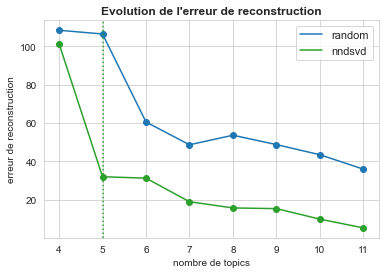

In [22]:
#Construction du vecteur des erreurs de reconstruction

from sklearn.decomposition import NMF

r = np.array([4,5,6,7,8,9,10,11])

#nmf avec init = 'nndsvd'
nmf_error=[NMF(n_components=i, 
               tol = 1e-3,  #réduction de la tolérance pour atteindre convergence
               max_iter = 500,
               init = 'nndsvd',
               random_state = 1,
               beta_loss = 'frobenius').fit(nmf_data).reconstruction_err_ for i in r]

#nmf avec init = 'random'
nmf_error_rand=[NMF(n_components=i, 
               tol = 1e-3,  #réduction de la tolérance pour atteindre convergence
               max_iter = 500,
               init = 'random',
               random_state = 1,
               beta_loss = 'frobenius').fit(nmf_data).reconstruction_err_ for i in r]


error_graph = pd.DataFrame({'nndsvd':nmf_error, 'random':nmf_error_rand}, index = r)



#Graph des erreurs de reconstructions

#courbe pour init random
plt.plot(r,error_graph["random"], label = 'random', color = 'tab:blue')
plt.scatter(r,error_graph["random"], label='_nolegend_', color = 'tab:blue')

#courbe pour init nndsvd
plt.plot(r,error_graph["nndsvd"], label = 'nndsvd', color = 'tab:green')
plt.scatter(r,error_graph["nndsvd"], label='_nolegend_', color = 'tab:green')
plt.axvline(5, color = 'tab:green', linestyle = ':')

plt.ylabel('erreur de reconstruction')
plt.xlabel('nombre de topics')
plt.title("Evolution de l'erreur de reconstruction", fontweight = 'bold')

plt.legend(prop={'size': 11})
plt.show()


Nous remarquons qu'en initialisant l'algorithme d'optimisation à "nndsvd", notre NMF commet en moyenne moins d'erreurs.    
Nous allons donc initialiser l'algorithme avec le paramètre <i>init</i> égal à <b>nndsvd</b>.    
Cela revient à initialiser la procédure avec une <i>Nonnegative Double Singular Value Decomposition (NNDSVD)</i> au lieu d'une SVM.

Pour le nombre optimal de topics à estimer, nous avons choisi de le fixer à 5 puisque l'erreur de construction atteint son "coude" à <b>r = 5</b>.    
A partir de ce rang, l'erreur de reconstruction décroit moins rapidement. 
De plus, nous voulons éviter de selectionner trop de topics puisque cela peut engendré du sur-apprentissage.


<b> Implémentation de la NMF </b>:    
Nous allons implémenter la NMF avec <i> init = 'nndsvd' </i> et <i>n_components = 5</i>.    
Nous allons aussi augmenter la tolérance ainsi que le nombre maximum d'itération de l'algorithme pour pouvoir atteindre un point de convergence.

In [23]:
nmf = NMF(n_components=5, 
          init = 'nndsvd', 
          tol = 1e-3,
          random_state = 1, 
          max_iter = 400).fit(nmf_data)

n_comp = nmf.get_params().get('n_components') 


<b> Matrice $\tilde{X}$ : </b>    
Cette matrice correspond à la projection de nos données de départ sur un espace engendré par nos 5 topics estimés.    
Les informations fournies par nos 11 covariables ont été résumé par les 5 méta-covariables estimées.

In [24]:
nmf_X = pd.DataFrame(nmf.fit_transform(nmf_data)).apply(lambda x : np.round(x,2))
nmf_X.columns = ["topic " + str(i) for i in range(1,n_comp + 1)]
nmf_X.head(5)

,topic 1,topic 2,topic 3,topic 4,topic 5
0,0.57,0.14,0.29,0.01,0.26
1,1.40,0.14,0.21,0.07,0.16
2,1.02,0.34,0.19,0.14,0.15
3,1.23,0.39,0.16,0.22,0.13
4,1.19,0.40,0.23,0.01,0.11


Les coefficients obtenues correspond aux points de nos observations au sein des 5 topics.

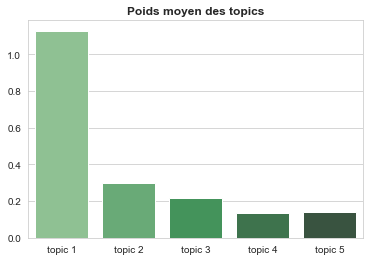

In [25]:
df_plot = nmf_X.melt(value_vars = nmf_X.columns).groupby(['variable']).mean()

splot = sns.barplot(x = df_plot.index, 
            y = 'value', 
            data = df_plot, palette = sns.color_palette("Greens_d", len(df_plot)));

plt.xlabel(xlabel = '');
plt.ylabel(ylabel = '');
plt.title('Poids moyen des topics', fontweight = 'bold');

Nos observations semblent en moyenne être mieux décrites d'abord par le premier topic puis par le deuxième.    
Nous allons donc utiliser ces topics pour répresenter graphiquement la matrice $\tilde{X}$ obtenue.

<b> Représentation graphique de $\tilde{X}$ : </b>

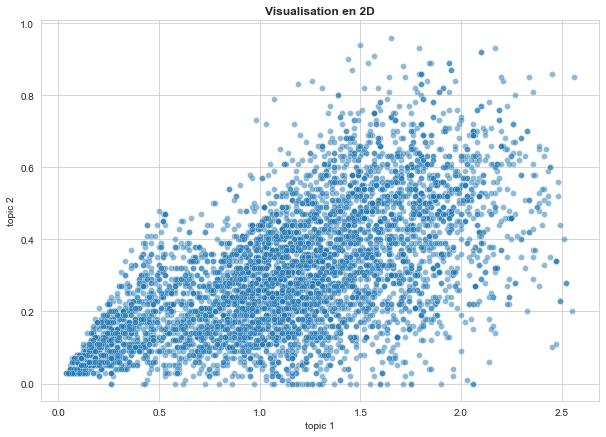

In [26]:
plt.figure(figsize=(10,7));
sns.scatterplot(x = 'topic 1', y = 'topic 2', data = nmf_X, alpha= 0.5);
plt.title("Visualisation en 2D", fontweight = 'bold');

Nous allons rajouter le troisième topic à notre graphique pour avoir une représentation en 3D.

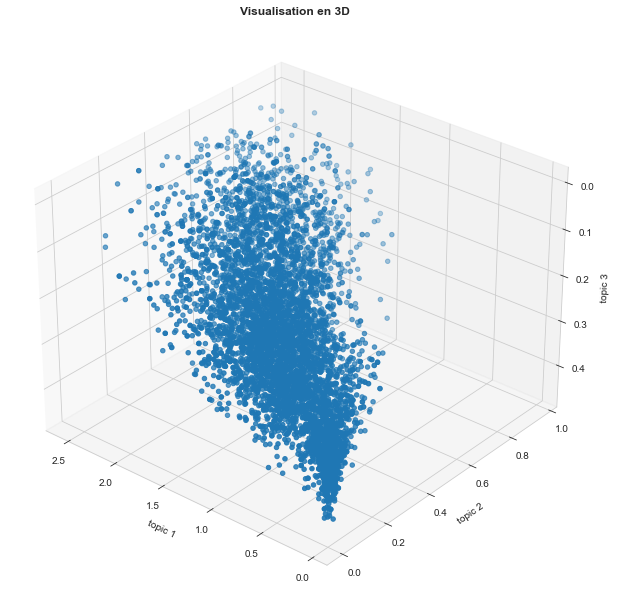

In [27]:
fig = plt.figure(figsize=(10,8))

ax = Axes3D(fig, auto_add_to_figure=False) 
fig.add_axes(ax) #rajouter au code existant

x = nmf_X.iloc[:, 0]
y = nmf_X.iloc[:, 1]
z = nmf_X.iloc[:, 2]

colormap = np.array(['tab:blue', 'tab:orange'])

ax.scatter(x, y, z, s = 20)
ax.set_xlabel('topic 1')
ax.set_ylabel('topic 2')
ax.set_zlabel('topic 3')
ax.view_init(-150, 50)

plt.title("Visualisation en 3D", fontweight = 'bold')
plt.show()

<b> Poids des variables au sein des topics </b> :    
La NMF nous permet aussi de construire une matrice $V$ qui correspond au poids de chacune de nos covariables au sein des 5 topics.

In [28]:
nmf_V = pd.DataFrame(nmf.components_, 
                     index =  ["topic" + str(i) for i in range(1,n_comp + 1)],
                     columns = nmf_data.columns)
nmf_V = nmf_V.apply(lambda x : np.round(x,4))

nmf_V.T.style.highlight_max(axis = 0)

,topic1,topic2,topic3,topic4,topic5
fixed acidity,1.420700,1.059000,8.422100,3.065400,21.679200
volatile acidity,0.032700,0.000000,0.783100,0.159600,0.761600
citric acid,0.106500,0.070800,0.218800,0.127900,0.812900
residual sugar,0.443300,0.267600,0.987800,33.543800,0.000000
chlorides,0.002400,0.016100,0.043900,0.024700,0.249600
free sulfur dioxide,4.839300,82.416100,0.000000,0.000000,0.000000
total sulfur dioxide,101.514000,0.000000,2.251500,0.000000,3.235700
density,0.302900,0.171200,1.965900,0.272200,0.960100
pH,0.974500,0.596300,6.882700,0.602800,2.513800
sulphates,0.108800,0.123000,0.959800,0.102100,1.050600


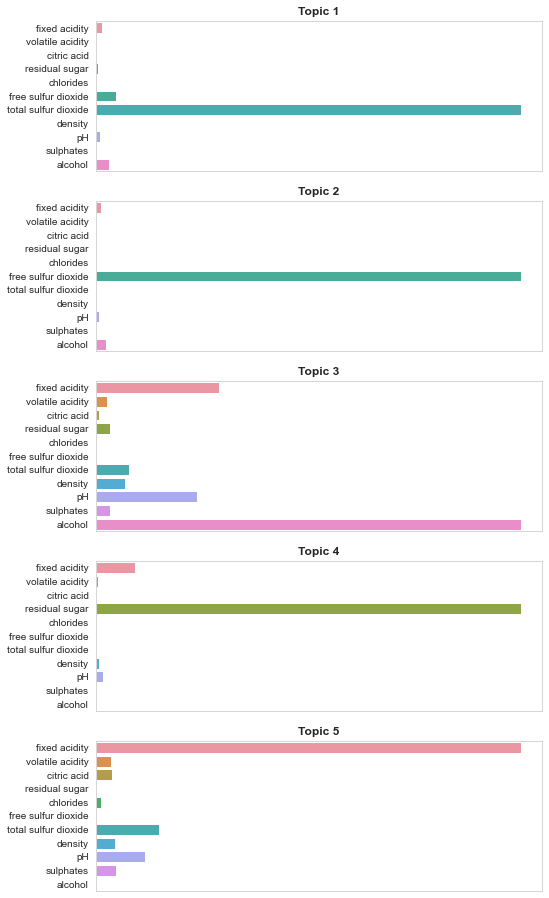


Les variables les plus influentes par topics sont :

topic1    total sulfur dioxide
topic2     free sulfur dioxide
topic3                 alcohol
topic4          residual sugar
topic5           fixed acidity


In [29]:
plt.figure(figsize=(8,16));

for i in range(1, nmf_V.T.shape[1]+1) :
    plt.subplot(5, 1, i)    
    ax = sns.barplot(y = nmf_V.T.index, 
                     x = pd.DataFrame(nmf_V.T.iloc[:,i-1]).columns[0], 
                     data = nmf_V.T)
    
    plt.title(f"Topic {i}", fontweight = 'bold')
    # plt.xticks(fontsize=9)
    plt.xlabel(xlabel = '')
    ax.axes.get_xaxis().set_visible(False)
    
plt.show()
print("")
print('Les variables les plus influentes par topics sont :')
print("")
print(nmf_V.T.apply(lambda x : x.idxmax(), axis = 0).to_string(dtype=False))


Nous avons donc réussi avec à la NMF à réduire la dimension $d$ de notre jeu de donnée initial grâce à la création de topics.    
Le nombre de covariables de notre dataset est passé de 11 à 5.    
Nous verrons dans une prochaine partie comment construire une méthode de clustering à partir des résutats de la NMF.    

## Spectral Clustering

Nous allons maintenant présenter le <b>spectral clustering</b> comme une méthode de clustering de covariables grâce au jeu de données <i> Wine Quality</i>.

Le principe du spectral clustering est de regrouper, grâce à une mesure de similarité, les covariables redondantes en paquets de covariables ou <b>meta-covariables</b>. Elle permet de réduire la dimension de l'espace des covariables en construisant $r < min(n,d)$ meta-covaribles (ou composantes connexes). 

Le spectral clustering construit les composantes connexes de $X$ à partir d'un graph de similarité où la dépendance entre deux observations est codée par une mesure de similarité. Deux noeuds (ou observations) appartiennent à la même composante connexe si il existe une arrête qui lie les deux points. Le but du spectral clustering est de <b>retrouver les $r$ composantes connexes </b> et de projeter les données sur un nouvel espace engendré par ces $r < d$ composantes.

Nous avons choisi de sélectionner un <b>sous-échantillon</b> de 300 observations du dataset <b>wine red</b> pour présenter le spectral clustering. 
Puisque nous allons construire et calculer des matrices de taille $n*n$, il semblait être plus judicieux de prendre un nombre d'observations réduit.

In [30]:
#supprimer l'affichage de la non-convergence du modèle
import warnings
warnings.filterwarnings('ignore')

#données pour le modèle
sc_data = wine_red.sample(n=300, random_state = 1)

Pour déterminer le nombre de composantes connexes, nous allons commencer par fixer le nombre de composantes à 11 afin de déterminer la matrice d'adjacence $A$, la matrice des degrées $D$, la matrice laplacienne $L$ du graph de similarité et donc les valeurs propres de $L$. Nous savons que le nombre de composantes connexes de notre jeu de donnée correspond au nombre de valeurs propres nulles de la matrice $L$.

<b> Adjacency matrix $A$</b>

In [31]:
#implémentation du spectral clustering 
from sklearn.manifold import SpectralEmbedding
sc = SpectralEmbedding(n_components = d, 
                       affinity = 'nearest_neighbors', 
                       n_neighbors = 5, 
                       random_state = 1)

k = sc.get_params().get('n_neighbors')

Le paramètre <i>affinity</i> correspond à la stratégie employée pour estimer la similarité entre deux points.    
En choisissant <i>nearest_neighbors</i>, nous avons choisi de construire le graph de similarité en fonction des 5 plus proches voisins d'un point.

La <b>mesure de similarité</b> est donc : 
- $W_{i,j} = 1$ si le point i appartient aux 5 plus proches voisins de j (vraie aussi pour j)
- $W_{i,j} = 0$ sinon

In [32]:
A_matrix = sc.fit(sc_data).affinity_matrix_.todense()
A_matrix

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

La matrice d'adjacence $A$ est calculée par la fonction <i> SpectralEmbedding </i> sous la forme d'une matrice sparse.    
Elle code l'existence d'un lien (arrête) entre deux noeuds du graph.


<b> Degree matrix $D$ </b>

In [33]:
D_matrix = np.zeros(A_matrix.shape)
np.fill_diagonal(D_matrix,np.sum(A_matrix, axis = 1))
D_matrix

array([[3.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 5. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 5. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 5.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 5.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 6.5]])

La matrice des degré $D$ est la matrice qui contient des informations sur le degré des noeuds.    
Le <b>degré</b> d'un noeud correspond au nombre d'arrêtes qui entre en contact avec ce noeud. 

<b> Laplacian matrix $L$ </b>

In [34]:
L_matrix = D_matrix - A_matrix
L_matrix

matrix([[2.5, 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 4. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 4. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 4.5, 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 4.5, 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 5.5]])

La matrice Laplacienne $L$ va nous permettre de retrouver les $r$ composantes connexes de $X$ puisque ces composantes correspondent aux $r$ vecteurs propres de valeur propre nulle de la matrice $L$.    
Ainsi, le nombre de composantes connexes correspond au nombre de valeurs propres nulles.


<b> Choix du nombre k optimal de clusters </b>
Nous allons commencer par représenter l'ensemble des valeurs propres de $L$ par ordre croissant. <br>

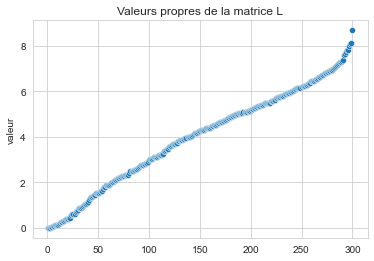

In [35]:
#valeurs propres de L
eig_values = scipy.linalg.eigh(L_matrix, eigvals_only = True)
# eig_values.sort()

#vecteurs propres de L
w, v = scipy.linalg.eig(L_matrix)
eig_vectors = v

#graph des valeurs propres
eigen_value = pd.DataFrame(eig_values, index = np.arange(1,len(eig_values)+1), columns = ['value'])
eigen_value[eigen_value < 0] = 0

sns.scatterplot(x = eigen_value.index, y = 'value', data = eigen_value);
plt.ylabel('valeur')
plt.title('Valeurs propres de la matrice L');

Concentrons-nous sur les dix premières valeurs propres afin de déterminer le nombre de valeurs propres nulles.

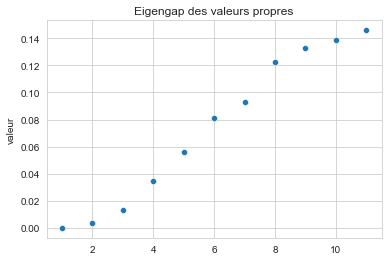


eigengap 1-2 : 0.0038
eigengap 2-3 : 0.0093
eigengap 3-4 : 0.0217
eigengap 4-5 : 0.021
eigengap 5-6 : 0.0253
eigengap 6-7 : 0.0117
eigengap 7-8 : 0.0298
eigengap 8-9 : 0.0298


In [36]:
#graph des valeurs propres
ax = sns.scatterplot(x = eigen_value.iloc[:11].index, 
                     y = eigen_value['value'].iloc[:11]);
plt.ylabel('valeur');
plt.title("Eigengap des valeurs propres");
plt.show()

#eigengaps
eigen_gaps = np.subtract(eigen_value['value'].iloc[1:9].to_numpy(),eigen_value['value'].iloc[:8].to_numpy())
print("")
print(f"eigengap 1-2 : {np.round(eigen_gaps[0],4)}")
print(f"eigengap 2-3 : {np.round(eigen_gaps[1],4)}")
print(f"eigengap 3-4 : {np.round(eigen_gaps[2],4)}")
print(f"eigengap 4-5 : {np.round(eigen_gaps[3],4)}")
print(f"eigengap 5-6 : {np.round(eigen_gaps[4],4)}")
print(f"eigengap 6-7 : {np.round(eigen_gaps[5],4)}")
print(f"eigengap 7-8 : {np.round(eigen_gaps[6],4)}")
print(f"eigengap 8-9 : {np.round(eigen_gaps[6],4)}")

En théorie, nous devrions choisir 8 ou 9 valeurs propres puisque l'eigengap est être maximisé pour ces deux valeurs propres. Cependant, nous savons que choisir trop de composantes connexes peut nous amener à faire du <b>sur-apprentissage</b>.

Nous avons donc choisit de fixer à <b>5 le nombre de composantes connexes</b> puisque même si l'eigengap n'est pas maximisé à cet étape, l'écart entre la cinquième et la sixième valeur propre reste important.

<b>Implémentation du Spectral Clustering</b>    
Maintenant que nous avons déterminé le nombre de composantes connexes de notre problème, nous pouvons projeter nos données sur un nouvel espace de dimension 5 < d.

In [37]:
#implémentation du Spectral Clustering:
sc_optimal = SpectralEmbedding(n_components = 5, 
                        affinity = 'nearest_neighbors', 
                        n_neighbors = 5, 
                        random_state = 1)

#nombre de composantes
sc_components = sc_optimal.get_params().get('n_components')

#df des composantes
sc_df = pd.DataFrame(sc_optimal.fit(sc_data).embedding_)
sc_df.columns = ['composante ' + str(i) for i in range(1,sc_components + 1)]

print(sc_df.head(10).to_string(index=False))

 composante 1  composante 2  composante 3  composante 4  composante 5
    -0.030497     -0.019501     -0.003768     -0.015310      0.010558
    -0.036043     -0.039306      0.022800      0.024663     -0.010900
    -0.007574      0.035325     -0.015109      0.021810     -0.031827
     0.013795      0.026754      0.041133      0.009223      0.033182
    -0.016682      0.021732     -0.036063     -0.034900      0.007576
    -0.000408      0.040649      0.006106      0.058340     -0.055504
     0.045189     -0.030064     -0.030212      0.015361      0.003505
    -0.000094      0.040725      0.007042      0.059342     -0.055994
    -0.032854     -0.027485      0.005403     -0.004233      0.006762
    -0.008930      0.033373     -0.018208      0.014058     -0.027707


Nous allons commencer par représenter les composantes connexes sur un plan à deux dimensions.

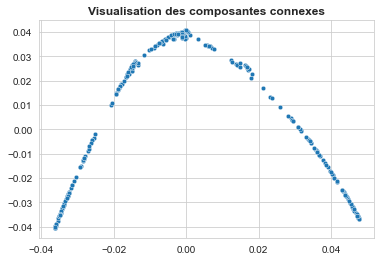

In [38]:
sns.scatterplot(x = sc_df['composante 1'], y = sc_df['composante 2'], s = 20);
plt.xlabel('');
plt.ylabel('');
plt.title("Visualisation des composantes connexes", fontweight = 'bold');

Un plan en deux dimensions ne semble pas suffisant pour représenter de manière pertinente les composantes.    
Nous allons donc passer à un plan tridimensionnel.

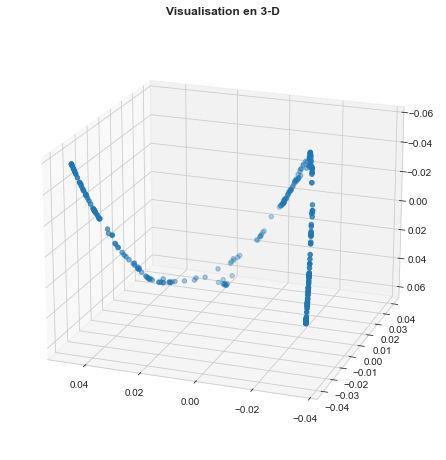

In [39]:
fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig, auto_add_to_figure=False) 
fig.add_axes(ax)

x = sc_df.iloc[:, 0]
y = sc_df.iloc[:, 1]
z = sc_df.iloc[:, 2]

ax.scatter(x, y, z, s = 20)
ax.view_init(-160, 70)
plt.title("Visualisation en 3-D", fontweight = 'bold');

plt.show()
print("")

Nous constatons graphiquement qu'il existe un certain nombre de poins non liés. Nous avons peut-être choisi la mauvaise mesure de similarité pour ce modèle ou le mauvais nombre de voisins à considérer pour le kNN.

Pour conclure, nous avons tout de même réussi à <b>synthétiser les informations portées par nos 11 covariables en 3 composantes connexes</b> grâce au Spectral Clustering. Cela nous a permit de réduit considérablement la dimension $d$ de l'espace des covariables.

Nous verrons dans une prochaine partie comment faire du clustering d'observations grâce au Spectral Clustering.

# Clustering (Par Laurène David)

## Non negative matrix factorization 

Nous allons maintenant utiliser la NMF du chapitre précédent pour faire du <b>clustering sur nos observations</b>.    
Nous savons que sous certaines conditions, la NMF est équivalent à du clustering par <b>K-means</b>.

<b> Centroïdes des k clusters :</b> <br>
Nous savons que les colonnes de la matrice $V^T$ peuvent être considéré comme les centroides des k clusters, qui appartiennet chacun à un espace de dimension $\mathbb{R}^d$.

In [40]:
centroid = nmf_V.T.copy()
centroid.columns = ['centroid ' + str(i) for i in range(1,centroid.shape[1] + 1)]
centroid

,centroid 1,centroid 2,centroid 3,centroid 4,centroid 5
fixed acidity,1.4207,1.0590,8.4221,3.0654,21.6792
volatile acidity,0.0327,0.0000,0.7831,0.1596,0.7616
citric acid,0.1065,0.0708,0.2188,0.1279,0.8129
residual sugar,0.4433,0.2676,0.9878,33.5438,0.0000
chlorides,0.0024,0.0161,0.0439,0.0247,0.2496
free sulfur dioxide,4.8393,82.4161,0.0000,0.0000,0.0000
total sulfur dioxide,101.5140,0.0000,2.2515,0.0000,3.2357
density,0.3029,0.1712,1.9659,0.2722,0.9601
pH,0.9745,0.5963,6.8827,0.6028,2.5138
sulphates,0.1088,0.1230,0.9598,0.1021,1.0506


<b> Clustering des observations </b> :    
Pour assigner un label (topic) à chaque observation, nous allons choisir le topic dont le poids est maximal.

In [41]:
nmf_labels = nmf_X.copy()
nmf_labels['label'] = nmf_X.idxmax(axis = 1).apply(lambda x : int(x[-1]))
nmf_labels.head(8).style.highlight_max(axis = 1, subset = nmf_labels.columns[:4])

,topic 1,topic 2,topic 3,topic 4,topic 5,label
0,0.570000,0.140000,0.290000,0.010000,0.260000,1
1,1.400000,0.140000,0.210000,0.070000,0.160000,1
2,1.020000,0.340000,0.190000,0.140000,0.150000,1
3,1.230000,0.390000,0.160000,0.220000,0.130000,1
4,1.190000,0.400000,0.230000,0.010000,0.110000,1
5,0.230000,0.030000,0.310000,0.040000,0.170000,3
6,0.110000,0.050000,0.370000,0.120000,0.160000,3
7,1.330000,0.090000,0.200000,0.070000,0.160000,1


Grâce à la nouvelle colonne "label", nous allons maintenant assigner un label à chaque observation.

In [42]:
nmf_data_label = nmf_data.copy()
nmf_data_label['label'] = nmf_X.idxmax(axis = 1).apply(lambda x : int(x[-1]))

nmf_data_label.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,9.2,0.28,0.41,1.0,0.042,14.0,59.0,0.99220,2.96,0.25,10.5,1
1,7.7,0.46,0.18,3.3,0.054,18.0,143.0,0.99392,3.12,0.51,10.8,1
2,7.1,0.15,0.34,5.3,0.034,33.0,104.0,0.99530,3.37,0.52,9.3,1
3,7.0,0.16,0.32,8.3,0.045,38.0,126.0,0.99580,3.21,0.34,9.2,1
4,6.4,0.16,0.44,1.2,0.051,39.0,122.0,0.99058,3.11,0.75,11.3,1


Nous allons d'abord chercher à estimer la <b>taille des différents clusters</b>.

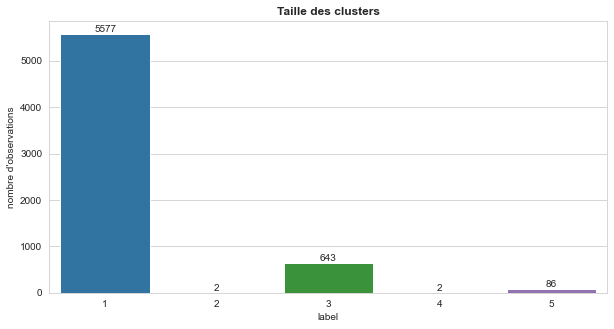

In [43]:
label_weight = pd.DataFrame(nmf_data_label['label'].value_counts()).reset_index().sort_values(by = ['index']).reset_index(drop = True)
label_weight.columns = ['label','count']

plt.figure(figsize=(10,5));
splot = sns.barplot(x = 'label', y = 'count', data = label_weight);
plt.title("Taille des clusters", fontweight = 'bold');
plt.ylabel("nombre d'observations");
plt.bar_label(splot.containers[0], fontsize = 10);

Les clusters sont très désequilibrés.    
Nous avons peut-être estimé trop de topics pour pouvoir construire des clusters de même taille.

<b> Visualisation des clusters </b>    
Nous allons représenter les clusters crées en fonction de <i>fixed acidity</i> et <i>volatile acidity</i>, qui ont été choisi de façon arbitraire simplement pour obtenir un graph en deux dimensions.

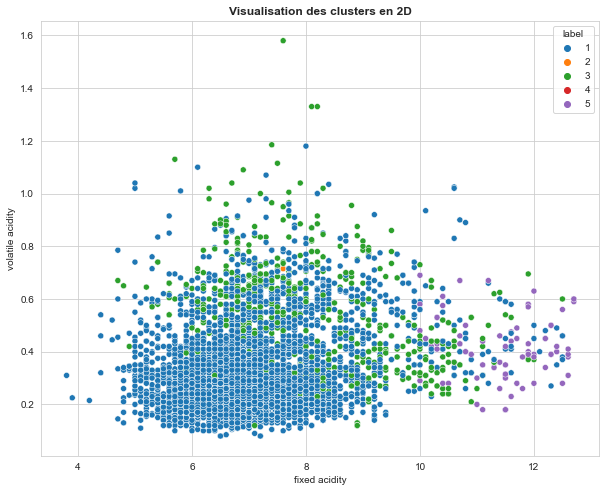

In [44]:
plt.figure(figsize=(10,8));
sns.scatterplot(x = 'fixed acidity', 
                y = 'volatile acidity', 
                data = nmf_data_label, 
                hue = 'label', 
                palette = sns.color_palette('tab10',5));
plt.title("Visualisation des clusters en 2D", fontweight = 'bold');

Nous constatons que les clusters crées se <b>chevauchent</b> et qu'il n'existe <b>pas de séparations nettes</b> entre les clusters.    
Le clustering par NMF n'est peut-être pas adapté à notre jeu de données ou le manque d'hétérogéneité des données ne nous a pas permis de construire des clusters concluants.

## Spectral Clustering

Le spectral clustering permet aussi de faire du <b>clustering d'observations.</b> Au lieu d'utiliser les composantes connexes pour projeter les données sur un espace de dimension réduit, les composantes connexes permettent de construire des clusters d'observations.    

Pour illuster le clustering par Spectral Clustering, nous allons utiliser le train split du dataset titanic    

In [45]:
data_clust = t_train

from sklearn.cluster import SpectralClustering

#construction du modèle
sc_clust = SpectralClustering(n_clusters = d, 
                              affinity = 'nearest_neighbors', 
                              n_neighbors = 4, 
                              assign_labels = 'kmeans') 

Nous allons d'abord choisir le nombre optimal de clusters en construisant la matrice Laplacienne $L$ et en determinant le nombre de ses valeurs propres qui sont nulles (comme pour la méthode de réduction de dimension).


<b>Choix des k clusters :</b>
Comme dans le cas du Spectral Clustering pour la réduction de dimension, le nombre de valeurs propres nulles de la matrice $L$ va nous permettre d'estimer le nombre $k$ de clusters à construire.

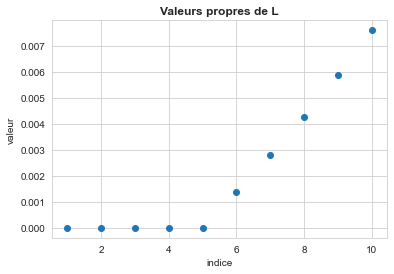

In [46]:
#matrice d'adjacence A
A_matrix_ = sc_clust.fit(data_clust).affinity_matrix_.todense()

#matrice des degrés D
D_matrix_clust = np.zeros(A_matrix_.shape)
np.fill_diagonal(D_matrix_clust,np.sum(A_matrix_, axis = 1))

#matrice Laplacienne L
L_matrix_clust = D_matrix_clust - A_matrix_

#valeurs propres de L
val_propre, vect_propre = scipy.linalg.eigh(L_matrix_clust)

#plot du graph
plt.scatter(np.arange(1,11),val_propre[:10]);
plt.xlabel('indice');
plt.ylabel('valeur');
plt.title('Valeurs propres de L', fontweight = 'bold');

Puisque les 5 premières valeurs propres de la matrice $L$ sont nulles, nous pouvons donc fixer le nombre de clusters à estimer à 5. De plus, choisir k = 4 pour construire la mesure de similarité par kNN nous a permis de faire apparaître des valeurs propres nulles bien distinctes, nous pouvons donc garder le paramètre <i>n_neighbors</i> à 4.

<br>
<b> Graph de similarité et composantes connexes </b> : <br>
Nous allons maintenant implementer le spectral clustering avec les paramètres donnés précédemment et construire les différentes composantes connexes grâce au <b>graph de similarité.</b> <br>
Le graph de similarité regroupe les points dits "similaires" en composantes connexes qui formeront les clusters de notre modèle. Nous notons tout de même que le lien entre clusters et composantes connexes n'est en pratique pas toujours vérifié. <br>
<br>

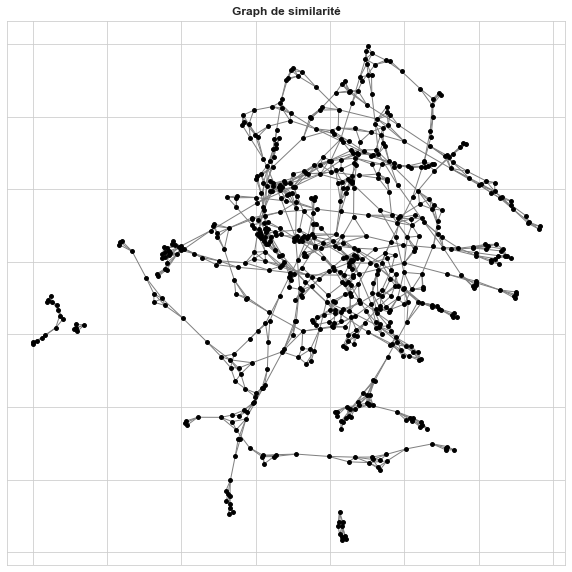

Le nombre de composantes connexes est 5


In [47]:
#Implémentation du spectral clustering
sc_clust_opt = SpectralClustering(n_clusters = 5, 
                              affinity = 'nearest_neighbors', 
                              n_neighbors = 4, 
                              assign_labels = 'kmeans') 

n_clusters_opt = sc_clust_opt.get_params().get('n_clusters')



#matrice d'adjacence pour la construction du graph
aff_ = sc_clust.fit(data_clust).affinity_matrix_.tocoo()
df_aff_ = pd.DataFrame({'node1': aff_.row, 'node2': aff_.col, 'edge_weight': aff_.data}).replace(0.5, 0)



#graph de similarité
plt.figure(figsize=(10,10)) 
plt.title('Graph de similarité', fontsize = 12, fontweight = 'bold')

G = nx.from_pandas_edgelist(df_aff_, 
                             source = 'node1', 
                             target = 'node2', 
                             edge_attr = 'edge_weight')

G.remove_edges_from(nx.selfloop_edges(G))

nx.draw_networkx(G, node_size=15, with_labels=False, node_color = 'black', edge_color = 'grey')
plt.show()

print(f'Le nombre de composantes connexes est {nx.number_connected_components(G)}')

Pour pouvoir identifier toutes les composantes, nous allons les tracer une par une.

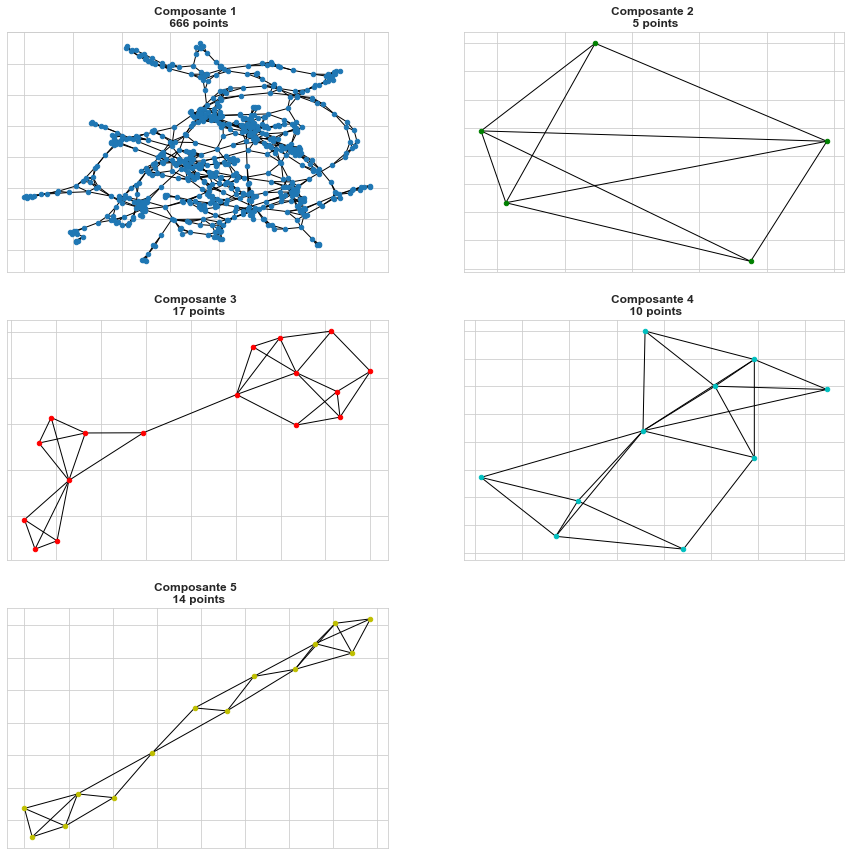

In [48]:
#extraction des 5 composantes connexes
connected_components = [G.subgraph(c) for c in nx.connected_components(G)]

#nombre de noeuds par composantes connexes
number_nodes = [x.number_of_nodes() for x in connected_components]

#graph des 5 composantes connexes
plt.figure(figsize=(15,15));

colors = ['tab:blue','g','r','c','y']

for i in range(1, nx.number_connected_components(G)+1) :
    plt.subplot(3, 2, i) 
    nx.draw_networkx(connected_components[i-1], node_color=colors[i-1], node_size=20, with_labels = False)
    plt.title(f"Composante {i} \n {number_nodes[i-1]} points", fontweight = 'bold')

plt.show()

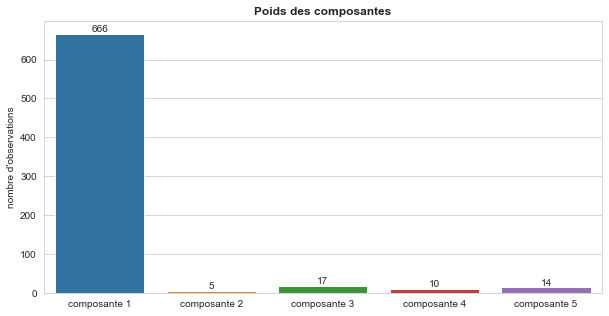

composante 1: 93.5%
composante 2: 0.7%
composante 3: 2.4%
composante 4: 1.4%
composante 5: 2.0%


In [49]:
#df des composantes
composantes_n = ['composante ' + str(x) for x in range(1,len(connected_components) + 1)]
perc_n = [str(np.round(100*x/sum(number_nodes),1)) + "%" for x in number_nodes]
cum_sum_n = [str(np.cumsum([100*x/sum(number_nodes) for x in number_nodes])[i]) + '%' for i in range(0,len(perc_n))]

composantes_ = pd.DataFrame({'composantes':composantes_n,
              'points':number_nodes,
              '% points':perc_n}).sort_values('points', ascending=False).sort_values(['composantes'])


#graph
plt.figure(figsize=(10,5));
splot = sns.barplot(x = 'composantes', y = 'points', data = composantes_);

plt.title('Poids des composantes', fontweight = 'bold');
plt.xlabel('');
plt.ylabel("nombre d'observations");
plt.bar_label(splot.containers[0], fontsize = 10);
plt.show();

print(f"composante 1: {composantes_['% points'][0]}")
print(f"composante 2: {composantes_['% points'][1]}")
print(f"composante 3: {composantes_['% points'][2]}")
print(f"composante 4: {composantes_['% points'][3]}")
print(f"composante 5: {composantes_['% points'][4]}")

<br>
Nous avons donc construit, à partir de la matrice d'adjacence $A$ et une mesure de similarité basée sur le kNN, cinq composantes connexes. <br>
Nous constatons tout de même que ces composantes sont très déséquilibrées avec la première composante qui comporte la majorité des observations. Nous allons voir dans cette prochaine partie si nos clusters se comportent de la même manière. <br>
<br>

<b> Clustering par K-Means :</b> <br>
Maintenant que nous avons déterminé le nombre optimal de clusters, nous pouvons assigner à chaque observation un label.<br>
Notre modèle de spectral clustering va construire ces clusters grâce à la méthode du K-means.

Regardons d'abord le poids de chaque label dans notre dataset.

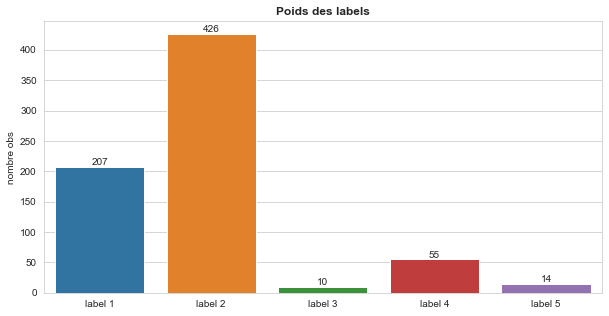

 labels  count count %
label 1    207   29.1%
label 2    426   59.8%
label 3     10    1.4%
label 4     55    7.7%
label 5     14    2.0%


In [50]:
#labels prédits pour chaque observation
labels_sc = sc_clust_opt.fit_predict(data_clust)
labels_plot = pd.DataFrame({'labels': ['label ' + str(i) for i in range(1,n_clusters_opt+1)] ,
                            'count':pd.Series(labels_sc).value_counts().sort_index()})
labels_plot['count %'] = labels_plot['count'].apply(lambda x : str(np.round(100*x/data_clust.shape[0],1)) + '%')


#graph des poids
plt.figure(figsize=(10,5));
plt.title("Poids des labels", fontweight = 'bold');
splot = sns.barplot(y = 'count', x = 'labels', data = labels_plot);
# plt.xlim((0,700));
plt.xlabel('');
plt.ylabel("nombre obs");
plt.bar_label(splot.containers[0], fontsize = 10);
plt.show()

print(labels_plot.to_string(index=False))

<br>
Les clusters obtenues ne semblent pas correspondre aux composantes connexes construits à l'étape précédente. 
Ils sont relativement désequilibré mais pas autant que les composantes connexes.

<br>
<b> Visualisation des clusters : </b> <br> 
Nous allons maintenant représenter les clusters obtenues. <br>

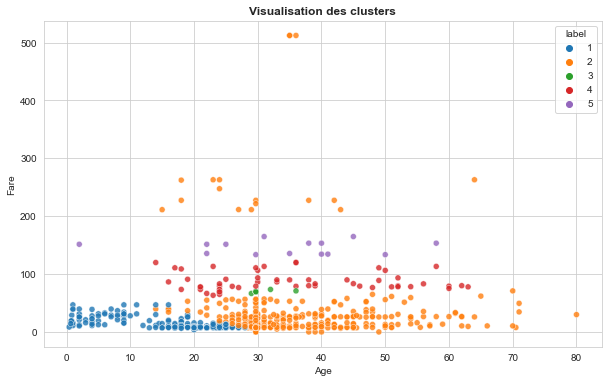

In [51]:
plt.figure(figsize=(10,6));

data_clust['label'] = labels_sc
data_clust['label'].replace({0:1, 1:2, 2:3, 3:4, 4:5}, inplace = True)

sns.scatterplot(y = 'Fare', x = 'Age', hue = 'label', alpha = 0.8, data = data_clust, palette = sns.color_palette('tab10',5));
plt.title("Visualisation des clusters", fontweight = 'bold');
# plt.ylim((-10,300));

Le résultat de notre clustering ne nous parait <b>pas très convainquant</b> puisqu'il ne semble pas exister de réelle séparation entre les clusters. Cela est peut-être dû à un manque d'hétérogénéité de nos données qui ne nous a pas permis de construire des clusters bien distinguables. La forme de nos clusters peut aussi être dû à la présence de valeurs extrêmes dans nos données qui faussent les clusters construits.

# SVM Vins (Par Allan Pendant)

## Préparation du Dataset

**Création du DataFrame**    
Nous allons <u>**fusionner les bases de données concernant le vin blanc et le vin rouge et créer une nouvelle variable qualitative nommée "type"**</u>.

**type = 0** si c'est un **vin blanc**    
**type = 1** si c'est un **vin rouge**

In [52]:
wine_red = pd.read_csv("winequality-red.csv", sep=';')
wine_white = pd.read_csv("winequality-white.csv", sep=';')

wine_red['type'] = [1]*wine_red.shape[0]
wine_white['type'] = [0]*wine_white.shape[0]

wine = pd.concat([wine_red, wine_white.iloc[:1700,:]], axis = 0)
wine = wine.sample(frac=1).reset_index(drop=True)

**Aperçu du Dataset**

In [53]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.2,0.32,0.47,5.1,0.044,19.0,65.0,0.99100,3.03,0.41,12.6,4,0
1,9.8,1.24,0.34,2.0,0.079,32.0,151.0,0.99800,3.15,0.53,9.5,5,1
2,7.7,0.75,0.27,3.8,0.110,34.0,89.0,0.99664,3.24,0.45,9.3,5,1
3,6.9,0.25,0.26,5.2,0.024,36.0,135.0,0.99480,3.16,0.72,10.7,7,0
4,7.6,0.31,0.29,10.5,0.040,21.0,145.0,0.99660,3.04,0.35,9.4,5,0


## Etude et objectif
<u>**L'objectif**</u> ici est d'utiliser les machines à vecteurs de support pour faire de la classification : nous allons essayer de **construire un modèle capable de prédire si un vin est un vin blanc ou un vin rouge** en fonction des variables `fixed acidity` et `pH` pour plus de facilité.

Visualisons tout d'abord nos données:

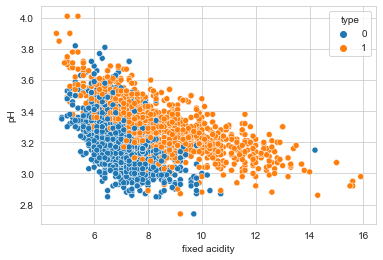

In [54]:
sns.scatterplot(data=wine, x="fixed acidity", y="pH", hue="type");

In [55]:
X = wine.loc[:,["fixed acidity", "pH"]]

In [56]:
y = wine.loc[:,"type"]

## Les différents Noyaux

Maintenant que nos données sont prêtes, nous allons montrer ce que donne l'utilisation de SVM avec les **noyaux Linéaire, Polynômial et Gaussien**

<u>**Les Noyaux :**</u>
Ils nous permettent de créer des hyperplans séparateur non-linéaires.
C'est aussi grâce à ces noyaux que nous pouvons procéder à une extension de dimension lorsque le nuage de points est non-linéairement séparable.

Le noyau va **calculer ce que donnerait le produit scalaire des variables étendues** dans l'espace de plus grande dimension sans pour autant réaliser la transformation des vecteurs et sans les manipuler dans l'espace de plus grande dimension qui sont des opérations coûteuses et compliquées.

$$k(x,y) = \langle \phi(x), \phi(y) \rangle$$

$k(.,.)$ : **Noyau**    
$\phi(w)$ : **Extension du vecteur $w$ dans un espace de plus grande dimension**

- <u>**SVM et noyau Polynômial**</u>    

$$\hspace{10cm}\small{\forall (c\geq0, d > 0)}$$
$$k(x,y) = (\langle x, y \rangle + c)^d$$ 

Ici nous allons dans un premier temps l'utiliser avec $c=0$ et $d=2$ et expliciter le calcul et faire une représentation graphique dans le nouvel espace de dimension 3 :

$$k(x,y) = (\langle (x_1, x_2), (y_1,y_2) \rangle + 0)^2 = (x_1y_1 + x_2y_2)^2$$
$$\hspace{8cm} =x_1^2y_1^2 + x_2^2y_2^2 + 2x_1y_1x_2y_2$$
$$\hspace{10cm} =\langle(x_1^2, x_2^2, \sqrt{2}x_1x_2) , (y_1^2, y_2^2, \sqrt{2}y_1y_2)\rangle$$


Créons une matrice **M** contenant les nouvelles coordonnées des vecteurs :

In [57]:
def higher_dim(x):
    return(x[0]**2, x[1]**2, np.sqrt(2)*x[0]*x[1])

In [58]:
M = np.zeros((len(y),3))

for i in range(len(y)):
    new_coord = higher_dim(X.iloc[i,:])
    for j in range(3):
        M[i,j] = new_coord[j]

In [1]:
# import plotly.express as px
# data = pd.DataFrame(M, columns=["x1²","x2²","√2x1x2"])
# data

#colors = y.apply(lambda x : {0 : "vins blanc", 1 : "vins rouge"}.get(x))
#fig = px.scatter_3d(data, x="x1²", y="x2²", z="√2x1x2",color=colors)
#fig.show()

Testons La performance de ce modèle :

In [62]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2, stratify=y)

In [64]:
svc_model = SVC(kernel='poly', degree=2)
svc_model.fit(X_train,y_train)

SVC(degree=2, kernel='poly')

In [65]:
svc_model.score(X_test, y_test)

0.8363636363636363

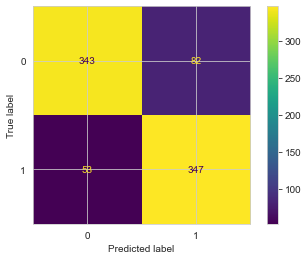

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(svc_model, X_test, y_test);

In [103]:
precision = 347/(347 + 82)
recall = 347/(347 + 53)
f1 = 2*(precision * recall)/(precision + recall)

In [104]:
print("Precision:", precision)
print("recall", recall)
print("f1_score:", f1)

Precision: 0.8088578088578089
recall 0.8675
f1_score: 0.8371531966224366


On atteint un niveau de **performance à 80%**

Voyons maintenant si on peut l'améliorer en **changeant le degré :**

In [69]:
degres = [1, 2, 3, 4, 5, 6]

v = []
for i in degres:
    model = SVC(kernel='poly', degree=i)
    cross_val = cross_val_score(model, X, y, cv=5, scoring="f1")

    v.append(cross_val.mean())

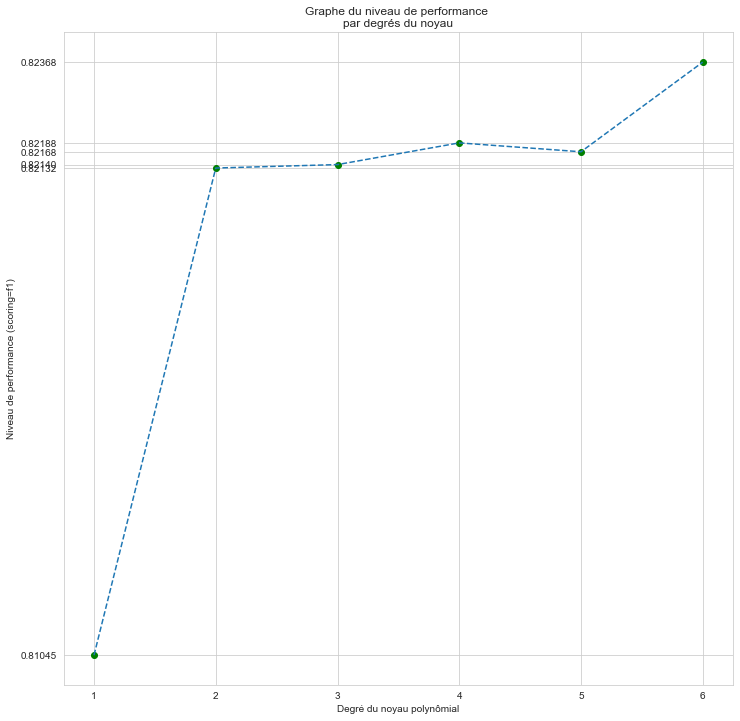

In [70]:
plt.figure(figsize=(12,12));
plt.plot(degres,v,"--");
plt.scatter(degres,v,c="green");
plt.xlabel("Degré du noyau polynômial")
plt.ylabel("Niveau de performance (scoring=f1)")
plt.title("Graphe du niveau de performance \npar degrés du noyau")
plt.yticks(v);
plt.grid(True);

Le niveau de **performance** varie entre 0.810 et 0.824 donc peu de différence entre les degrés et est **maximal** pour un **degré égale à 6**.

Visualisons les données avec les différents hyperplans séparateur par degrés :

In [71]:
def make_meshgrid(x, y, h=0.02):

    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

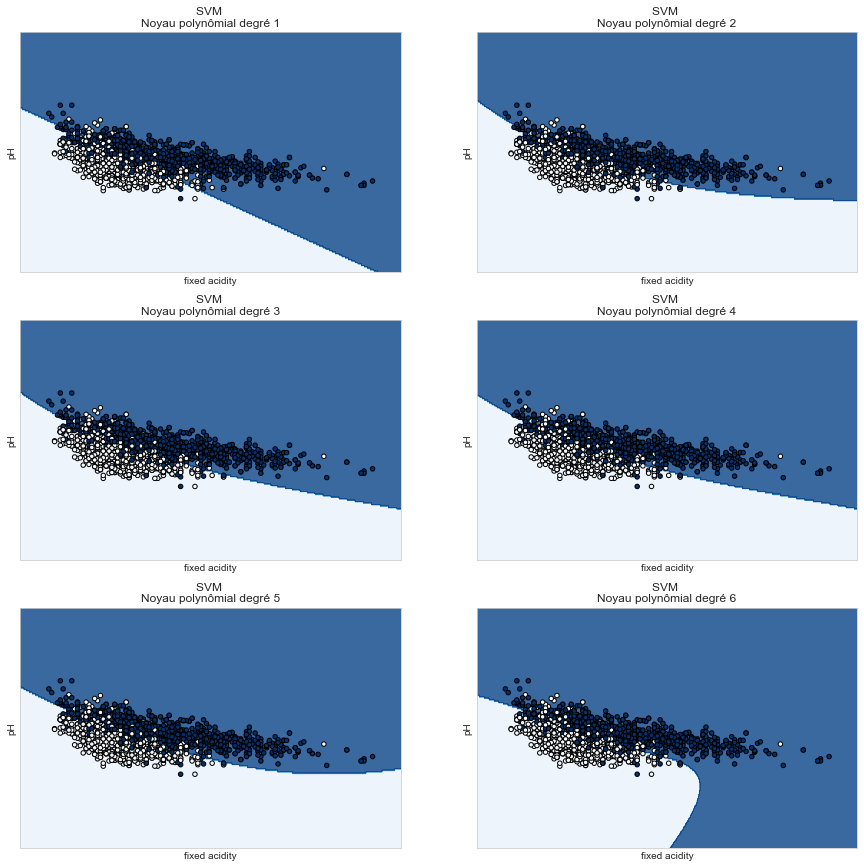

In [72]:
degres = [1, 2, 3, 4, 5, 6]

X0, X1 = X.iloc[:, 0], X.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)

f, axs = plt.subplots(3,2,figsize=(15,15))

for i in degres:

    plt.subplot(3, 2, i)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    model = SVC(kernel='poly', degree=i)
    model.fit(X_train,y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues, alpha=0.8)

    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Blues, s=20, edgecolors="k")
    plt.xlabel('fixed acidity')
    plt.ylabel('pH')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(f"SVM \nNoyau polynômial degré {i}")

plt.show()

- <u>**SVM et noyau linéaire**</u>  
$$k(x,y) = \langle x, y \rangle$$

Ce noyau est **équivalent au cas vu ci-dessus** avec $c=0$ et $d=1$ !

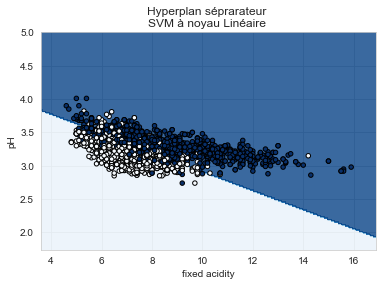

In [73]:
model = SVC(kernel='linear', random_state=3)
clf = model.fit(X_train, y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Hyperplan séprarateur \nSVM à noyau Linéaire ')
# Set-up grid for plotting.
X0, X1 = X.iloc[:, 0], X.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.Blues, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.Blues, s=20, edgecolors='k')
ax.set_ylabel('pH')
ax.set_xlabel('fixed acidity')
ax.set_title(title)
plt.show()

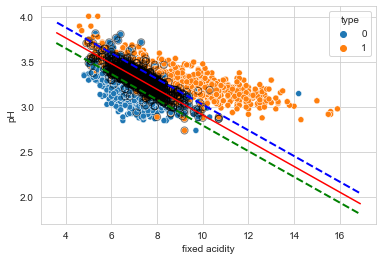

In [74]:
sns.scatterplot(x=X0,y=X1, hue=wine["type"]);

w = clf.coef_[0]           # w consists of 2 elements
b = clf.intercept_[0]      # b consists of 1 element
x_points = np.linspace(X0.min() - 1, X0.max() + 1)    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');


plt.scatter(clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1], 
            s=50, 
            facecolors='none', 
            edgecolors='k', 
            alpha=.5);

# Step 2 (unit-vector):
w_hat = clf.coef_[0] / (np.sqrt(np.sum(clf.coef_[0] ** 2)))
# Step 3 (margin):
margin = 1 / np.sqrt(np.sum(clf.coef_[0] ** 2))
# Step 4 (calculate points of the margin lines):
decision_boundary_points = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin
# Plot margin lines
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--', 
         linewidth=2)
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--',
         linewidth=2)

In [75]:
model = SVC(kernel='linear')
cross_val = cross_val_score(model, X, y, cv=10, scoring="f1")
cross_val.mean()

0.8215031014752683

- <u>**SVM et noyau Gaussien**</u>

$\forall x,y\in\mathbb{R}$

$$k(x,y) = e^{-\frac{(x - y)^2}{2}}$$

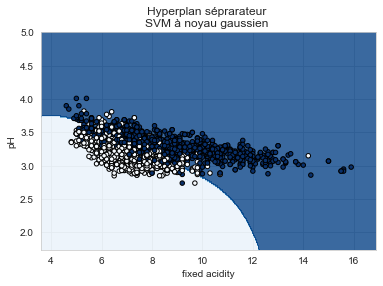

In [76]:
model = SVC(kernel='rbf', random_state=3)
clf = model.fit(X_train, y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Hyperplan séprarateur \nSVM à noyau gaussien ')
# Set-up grid for plotting.
X0, X1 = X.iloc[:, 0], X.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.Blues, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.Blues, s=20, edgecolors='k')
ax.set_ylabel('pH')
ax.set_xlabel('fixed acidity')
ax.set_title(title)
plt.show()

In [77]:
model = SVC(kernel='rbf')
cross_val = cross_val_score(model, X, y, cv=10, scoring="f1")
cross_val.mean()

0.8198622891087071

<u>**Commentaires :**</u>    
Dans notre exemple, les **trois noyaux présentés** fournissent un niveau de **performance assez similaires**, **proche de 80%**

# Méthodes de boosting (Par Safa Hamdan)

La mécanique du boosting ressemble à celle du bagging à quelques différence près :

   - étape 1 : génère un sous-échantillon du jeu de données initial (contrairement au bagging qui en génère plusieurs)
   - étape 2 : il va entraîner ce modèle
   - étape 3 : l'algorithme va ensuite crée une nouvelle version du modèle qui aura "appris" du modèle précédent
   - étape 4 : l'algorithme va répéter l'étape 3 et va entraîner chaques nouveaux modèles k sur les résultats du modèle k-1 pour crée le modèle le plus optimal/ le plus pure.
   
   

## AdaBoost

AdaBoost model, ou Adaptive Boosting model, est le premier modèle de boosting a avoir été itroduit en classification. Il fonctionne ainsi :

   Soit n observation $(x_1,y_1),...,(x_n,y_n)$ tous initialement de poids $w_i$ égals :
   $$w_i(x_i,y_i)=\frac{1}{N} \ \forall i \in {1,2,...,n}$$
   avec N étant le nombre de lignes total de notre échantillon. Cette échantillon nous servira pour crée notre premier "weak learner" $g_1$ qui sont des arbres de décisions simple.
   On entrain donc ce premier weak learner à minimiser le taux d'erreur de classification $\mathcal{R}_n$ :
   
   $$\mathcal{R}_n(g_1,w) \ = \ \sum^n_{i=1} \frac{w_i}{\sum^n_{j=1}w_j}\mathbb{1}_{y_i\neq g_1(x_i)} $$

Notons que pour les autres itérations, on généralisera à $g_1 = g$.
Puis on crée un nouveau weak learner de celui-ci en modifiant les poids. On rajoute plus de poids aux observations correctement classifié et moins de poids à celles qui ne le sont pas.

Puis nous réitérons jusqu'à avoir classifieur correct. Notons aussi qu'il est possible de sur-éstimer le modèle sur des données en grandes dimensions ou si le dataset n'est pas assez équilibré mais il existe des méthodes comme the k_folds qui permet d'arrêté les itérations de l'AdaBoost avant que le modèle ne soit sur-éstimé.

### Préparons le jeu de donnée 
   Nous allons travailler sur le jeu de donnée "titanic", accompagné de ses jeux de données de teste et d'entraînement "test-data" et "train-data".

In [78]:
from sklearn.ensemble import AdaBoostClassifier
titanic = pd.read_csv("titanic.csv",index_col=False)
titanic_test =  pd.read_csv("test-data.csv",index_col=False)
titanic_train =  pd.read_csv("train-data.csv",index_col=False)

titanic.head()

,PassengerId,Survived,Pclass,Lname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


Pour expliquer un peu le dataset, voici quelque commentaires sur certaines variables :

   - 'Survived' défini si le passager est décédé (0) ou s'il a survecu (1)
   - 'Age' représente l'age du passager et s'il est estimer, il sera alors écrit comme xx.5
   - 'Pclass' fait référence à la class à laquelle appartenait le passager (1er classe, 2ème classe ou 3ème classe)
   - 'SibSp' défini le nombre de frères est soeurs ou conjoint du passager, étant à bord du Titanic (maîtresses et fiancé n'étant pas pris en compte)
   - 'Parch' défini le nombre de parents/ enfants du passager, étant à bord du Titanic (les enfants accompagné de leurs nounous n'étant pas pris en compte et donc Parch=0 pour eux)
   - 'Fare' représente le prix du billet du passager.
   - 'Embarked' fait référence au port d'embarquation.

<b> Modification de 'titanic' </b> <br>
On remarque que dans titanic_train et titanic_test, les données on été décomposées pour obtenir majoritairement des données binaires. Transformont 'titanic' pour avoir les mêmes variables, donc nous devons décomposer les variables : 'Pclass', 'Sex', 'Parch' et 'Embarked' en autant de colonnes que de nombres de catégory dans chaques variables.

In [79]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
test_class = pd.DataFrame(encoder.fit_transform(titanic[['Pclass']]).toarray())
test_class.columns = ["Pclass_1", "Pclass_2" , "Pclass_3"]

titanic['Sex_female'] = titanic["Sex"].str[:7]
titanic['Sex_female'] = titanic['Sex_female'].apply(lambda x : 1 if 'female' in x else 0)
titanic['Sex_male'] = titanic["Sex"].str[:4]
titanic['Sex_male'] = titanic['Sex_male'].apply(lambda x : 1 if 'male' in x else 0)

test_SibSp = pd.DataFrame(encoder.fit_transform(titanic[['SibSp']]).toarray())
test_SibSp.columns = ["SibSp_0","SibSp_1","SibSp_2","SibSp_3","SibSp_4","SibSp_5"]

test_Parch = pd.DataFrame(encoder.fit_transform(titanic[['Parch']]).toarray())
test_Parch.columns = ["Parch_0","Parch_1","Parch_2","Parch_3","Parch_5"]

titanic['Embarked_S'] = titanic['Embarked'].str[:1]
titanic['Embarked_S'] = titanic['Embarked_S'].apply(lambda x : 1 if x=='S' else 0)
titanic['Embarked_C'] = titanic['Embarked'].str[:1]
titanic['Embarked_C'] = titanic['Embarked_C'].apply(lambda x : 1 if x=='C' else 0)
titanic['Embarked_Q'] = titanic['Embarked'].str[:1]
titanic['Embarked_Q'] = titanic['Embarked_Q'].apply(lambda x : 1 if x=='Q' else 0)

titanic = titanic.join([test_class,test_SibSp,test_Parch])

titanic = titanic.drop(["Pclass","Sex","SibSp","Parch","Embarked"],axis=1)

<b> Sélection des variables du modèle </b><br>
Nous allons regarder la corrélation ainsi que la méthode de sélection par variance pour construire notre modèle. Nous allons essayer de prédire la probabilité de survivre ('Survived'). <br>
Soulignons une spécificité qu'a AdaBoost : l'algorithme n'est pas affecté par les variables déséquilibrées puisqu'il s'entraîne pour réduire le taux d'erreur de classification à chaque itération. Donc que les variables sont déséquilibrées ou non, cela n'affectera pas l'algorithme et nous n'avons pas besoin d'être trop regardant sur ce paramètre.

<AxesSubplot:>

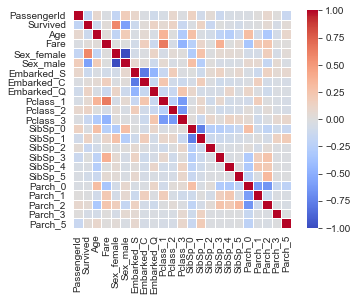

In [80]:
cor = titanic.corr() 
sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=0.5,xticklabels=True, yticklabels=True )

Nous remarquons qu'il n'y a pas énormément de variables corrélées, mise à part 'Sex_female' avec 'Sex_male' et avec un coefficient de corrélation plus faible, 'Embarked_C' avec 'Embarked_S' et 'Parch_1/2' avec 'Parch_0'. 

<b>Sélection par variance </b><br>

Nous devons maintenant sélectionner les variables explicatives du modèles. La méthode de sélection par variance permet de calculer la variance de chacune des caractèristiques et retire celle qui n'atteigne pas le seuil demandé.

Ici il est de 0.1, car un seuil à 0.5 (soit le seuil par défault) le nombre de variables sélectionner est égal à 2 et 4 pour un seuil de 0.2, ce qui n'est pas arbitrairement correcte. Nous avons donc réduit le seuil et retirer une variables au hasard pour les couples de variables qui montraient une corrélation trop élevée :

In [81]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


selection = variance_threshold_selector(titanic_train.drop(['Survived','Sex_female', 'Embarked_C'],axis=1),0.1)
selection

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_male,SibSp_0,SibSp_1,Parch_0,Parch_1,Embarked_S
0,28.500000,7.2292,0,0,1,1,1,0,1,0,0
1,27.000000,10.5000,0,1,0,0,1,0,1,0,1
2,29.699118,16.1000,0,0,1,0,0,1,1,0,1
3,29.699118,0.0000,1,0,0,1,1,0,1,0,1
4,17.000000,8.6625,0,0,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
707,24.000000,69.3000,1,0,0,0,1,0,1,0,0
708,22.000000,7.2500,0,0,1,1,1,0,1,0,1
709,29.699118,221.7792,1,0,0,1,1,0,1,0,1
710,12.000000,11.2417,0,0,1,1,0,1,1,0,0


Regardons maintenant s'il existe des valeurs manquantes dans nos variables sélectionnées, tout datasets confondus :

In [82]:
print('dataset titanic: \n', titanic[['Age','Fare','Sex_male','Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']].isnull().any())
print('dataset titanic_train: \n',titanic_train[['Age','Fare','Sex_male','Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']].isnull().any())
print('dataset titanic_test: \n',titanic_test[['Age','Fare','Sex_male','Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']].isnull().any())

dataset titanic: 
 Age            True
Fare          False
Sex_male      False
Pclass_1      False
Pclass_2      False
Pclass_3      False
SibSp_0       False
SibSp_1       False
Parch_0       False
Parch_1       False
Embarked_S    False
dtype: bool
dataset titanic_train: 
 Age           False
Fare          False
Sex_male      False
Pclass_1      False
Pclass_2      False
Pclass_3      False
SibSp_0       False
SibSp_1       False
Parch_0       False
Parch_1       False
Embarked_S    False
dtype: bool
dataset titanic_test: 
 Age           False
Fare          False
Sex_male      False
Pclass_1      False
Pclass_2      False
Pclass_3      False
SibSp_0       False
SibSp_1       False
Parch_0       False
Parch_1       False
Embarked_S    False
dtype: bool


On voit que la variable 'Age' dans le dataset 'titanic' à une ou plusieurs valeurs manquantes. Nous allons utiliser la méthode du KNN-voisin, qui va essayer de voir dans les k-premiers voisins, une lignes qui ressemblerais à celle où se trouve la valeurs manquantes, pour pouvoir identifier quel age serait cohérent de lui attribuer.

Sachant que nous n'utilisons 'titanic' que pour chercher le score de la cross validation, cette méthode est efficace pour changer le dataset sans réels impactes sur les prédictions.

In [83]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
titanic.Age = imputer.fit_transform(titanic['Age'].values.reshape(-1, 1))

titanic[['Age','Fare','Sex_male','Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']].isnull().any() 

Age           False
Fare          False
Sex_male      False
Pclass_1      False
Pclass_2      False
Pclass_3      False
SibSp_0       False
SibSp_1       False
Parch_0       False
Parch_1       False
Embarked_S    False
dtype: bool

In [84]:
X_test=titanic_test[['Age','Fare','Sex_male',
                               'Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']]
X_train=titanic_train[['Age','Fare','Sex_male',
                               'Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']]
Y_test=titanic_test[['Survived']]
Y_train=titanic_train[['Survived']]

### Sélection des paramètres

Maintenant que les variables de notre modèle ont été décidé, choisissons nos paramètres. Nous allons nous focaliser sur un paramètre : 'n_estimators' car les autres sont à choisir par le codeur en fonction de son jeu de données et que si 'n_estimators' est correctement choisi, 'learning_rate' (la contribution que le k-1$^{ème}$ algorithme va apporter au k$^{ème}$) peut être laissé à 1.0 par défault car les deux paramètres intéragissent entre eux. <br>
AdaBoost cherche à minimiser l'erreur quadratique moyenne pour trouver les meilleures distributions des poids pour chaques itérations, nous allons donc utiliser se critère pour sélectionner les coefficients de notre paramètre.

<b> Sélection du 'n_estimators'</b><br>
    Le 'n_estimators' désigne le nombre d'itérations que va faire le modèle avant d'arriver à l'arbre final. Notons qu'une fois ayant trouvé le premier coefficient minimisant le mse, nous n'avons pas besoin de chercher plus loin, même s'il existe d'autres coefficients le minimisant:

In [85]:
from sklearn.metrics import mean_squared_error
mse=[]
for k in range(1,100):
    BadaBoost = AdaBoostClassifier(n_estimators=k)

    # Train Decision Tree Classifer
    BadaBoost = BadaBoost.fit(X_train,Y_train.values.ravel())

    #Predict the response for test dataset
    Y_pred = BadaBoost.predict(X_test)
    
    mse.append(mean_squared_error(Y_test, Y_pred))

(0.0, 6.0)

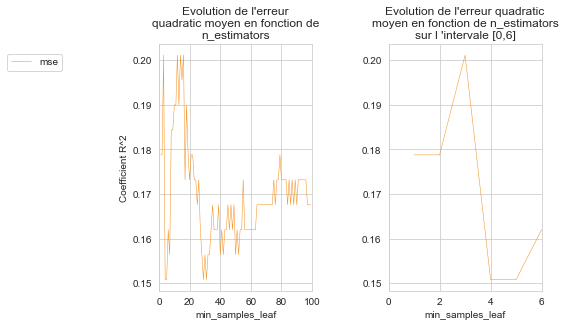

In [86]:
from textwrap import wrap
R=range(1,100)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)

ax1.plot(R, mse, linewidth=0.5, color='#F5911F',label='mse')
ax2.plot(R, mse, linewidth=0.5, color='#F5911F',label='mse')

ax1.set_title('\n'.join(wrap('Evolution de l\'erreur quadratic moyen en fonction de n_estimators')))
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('mse')

ax1.legend(bbox_to_anchor=(-0.6, 0.98))
ax1.title.set_text('\n'.join(wrap('Evolution de l\'erreur quadratic moyen en fonction de n_estimators',30)))
ax2.title.set_text('\n'.join(wrap('Evolution de l\'erreur quadratic moyen en fonction de n_estimators sur l \'intervale [0,6]',33)))
ax1.set_xlabel('min_samples_leaf')
ax2.set_xlabel('min_samples_leaf')
ax1.set_ylabel('Coefficient R^2')

ax1.set_xlim(0,100)
ax2.set_xlim(0,6)

In [87]:
mse_df=pd.DataFrame(mse)
np.where(np.any(mse_df==min(mse),axis=1))

(array([ 3,  4, 28, 30], dtype=int64),)

Comme l'index commence à 0, le n_estimators le plus petit, minimisant l'erreur quadratique moyen est n_estimators=4. Nous avons maintenant notre modèle :

In [89]:
from sklearn.metrics import precision_score, recall_score, mean_squared_error
BadaBoost = AdaBoostClassifier(n_estimators=4,
                         learning_rate=1)

model_Ada = BadaBoost.fit(X_train, Y_train.values.ravel())

Y_pred = model_Ada.predict(X_test)

print("Accuracy:",precision_score(Y_test, Y_pred,average = 'weighted'))
print("Recall:",recall_score(Y_test,Y_pred,average = 'weighted'))
print("mse des prédictions:",mean_squared_error(Y_test,Y_pred))

Accuracy: 0.8486342419759679
Recall: 0.8491620111731844
mse des prédictions: 0.15083798882681565


Les résultats optenu en précision et recall sont plutôt bons, mais allons un peu plus loin que faisons une validation croisé sur les K-Flods

In [90]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 9)

In [91]:
from sklearn.model_selection import cross_val_score

X=titanic[['Age','Fare','Sex_male',
                               'Pclass_1','Pclass_2','Pclass_3','SibSp_0','SibSp_1','Parch_0','Parch_1','Embarked_S']]
Y=titanic[['Survived']]
results = cross_val_score(model_Ada, X, Y.values.ravel(), cv = kfold)
print(results.mean())

0.8148148148148148


Notre modèle prédit alors les bonnes valeurs à 81%.

### Visualisation des itérations

Nous allons faire ce que nous avons fait plus haut mais pour voir les diagrammes en boîtes de chaque arbres en fonction du score de cross validation, pour chaque itérations demandées. En faisant ceci, nous observons le comportement de chacun de ces arbres après un certains nombre d'itéations, et surtout le comportement global d'AbaBoost sur notre modèle. Ici, nous allons comparer les itérations trouvées plus haut, qui minimisaient l'erreur quadratique moyen pour comparer leurs comportements :

>4 0.815 (0.058)
>5 0.796 (0.064)
>29 0.770 (0.069)
>31 0.744 (0.063)


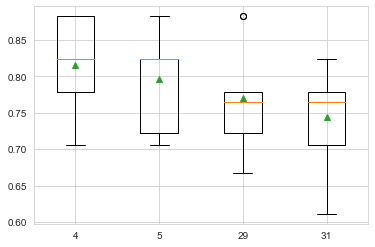

In [92]:
from statistics import mean
from matplotlib import pyplot

def Badabast_models():
    Badabast = dict()
    # define number of trees to consider
    n_trees = [4,5, 29,31]
    for n in n_trees:
        Badabast[str(n)] = AdaBoostClassifier(n_estimators=n,learning_rate=1)
    return Badabast

results, names = list(), list()
Badabast = Badabast_models()
for name, model_Ada in Badabast.items(): 
# evaluate the model
    scores = cross_val_score(model_Ada, X, Y.values.ravel(), cv = kfold)
# store the results
    results.append(scores)
    names.append(name)
# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Plusieurs choses sont intéressantes dans cette représentation. On voit que nous avons une tendance décroissante mais on observe également que la distribution des données dans le modèle devient plus grande quand n_estimators augmente. Ce qui fait sens car nous n'avons pas autant d'observations réels que de valeurs d'entraînement. <br>
Le choix de 'n_estimators=4' est donc adéquat.

## XGBoost

XGBoost, ou eXtremeGradient Boosting est une version du gradiant boosting. XGBoost va aussi agir sur un concept de pondération mais commence sa première itération en overfittant le modèle pour ensuite l'améliorer en minimisant une fonction objective qui va viser à éstimer à quel point le modèle prédit est proche du modèle d'entraînement.<br>
Cette fonction objective est la somme entre le coût quadratique entre les prédictions du modèle et les valeurs des données d'entraînement et une variable de réglarisation.<br>

La variable de régularisation permet de "pénaliser " le modèle quand il devient trop complèxe. Ces deux composantes permet de trouver le modèle le plus simple mais aussi le plus juste possible.

Coût quadratique : \ $L(y_{ent},f^{k})=(y_{ent}-f^k(x))^2$<br>
Variable de régulation : \ $\gamma(g(x_i))$

$$fonction \ objective \ \ \ = L(y_{ent},f^k) + \gamma(g(x_i))$$

Pour la classification, cette fonction s'appelle la fonction de log vraisemblance negative ou NLL pour negative log loss :

$$fonction \ objective \ \ \ = \sum_i (y_iln(1+e^{-\hat{y}_i})+(1-y_i)ln(1+e^{\hat{y}_i})$$

Où gamma est le coefficient qui, à chaque noeud, va permettre à celui-ci de se diviser si le coût quadratique de ses noeuds enfants atteint un certain seuil. Dans certaines littératures, on va remplacer $\gamma$ par $\alpha$ qui est connu sous le nom de "régularisation-l1" qui agit de la même façon qui aura plutôt un impact sur les feuilles de l'arbre plutôt que les noeuds, ce qui peut être suffisant pour des régressions logistiques ou linéaires.<br>

L'algorithme s'auto-évalue aussi par validation croisée à chaque itération, ce qui fait que, même s'il est plus long que les autres algorithmes de boosting, il est à prime abord, un algorithme qui réduit considérablement la probabilité de faire des mauvaises prédictions.

### Préparation du modèle

XGBoost n'a pas vraiment besoin de tuning sur ses paramètres, si nous les comprennons tous bien et que nous sachons ce que nous cherchons à prédire. Comme notre variable cible est binaire, 'objective' et 'eval_metric' sont prédéfinis. Nous allons nous focaliser sur la recherche des meilleurs paramètres 'n_estimators' qui est analogue à celui utilisé dans AdaBoost et 'max_depth' qui va fixer la profondeur maximale des arbres que le modèle crée. Gamma ne sera pas inclus dans notre modèle, celui-ci n'étant pas assez complèxe.

In [98]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

Passons directement par la comparaison des différents 'n_estimators' par comparaison des validations croisées sur les K-folds et qui va établir un score non pas sur l'accuracy mais la perte log vraisemblance negative, donc la fonction objective que nous avons explicité plus haut. Donc le plus bas notre score sera, le meilleur sera notre modèle :

Meilleurs score : -0.455952 avec {'n_estimators': 8}


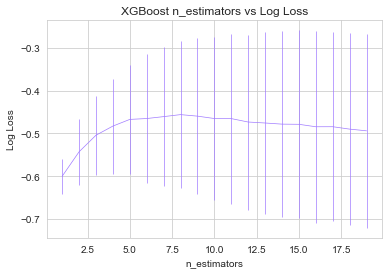

In [99]:
label_encoded_y = LabelEncoder().fit_transform(Y.values.ravel())
n_estimators = range(1, 20, 1)
XGB_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr',use_label_encoder=False)

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(XGB_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)


print("Meilleurs score : %f avec %s" % (grid_result.best_score_, grid_result.best_params_))

pyplot.errorbar(n_estimators, grid_result.cv_results_['mean_test_score'], linewidth=0.7,color='#A17CFF', yerr=grid_result.cv_results_['std_test_score'])
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

Le n_estimators qui minimise la log vraisemblance negative est 'n_neighbors=8'. On remarque que les bruits la marche d'erreur est depuis en plus grande quand n_estimators augmente. Ce qui, encore une fois, fait sens car nous n'avons pas autant d'observation réels que de valeur d'entraînement.<br>
Appliquons encore une fois la même méthode mais cette fois-ci pour trouver le meilleur 'max_depth' :

Meilleurs score : -0.455952 avec {'max_depth': 6} 


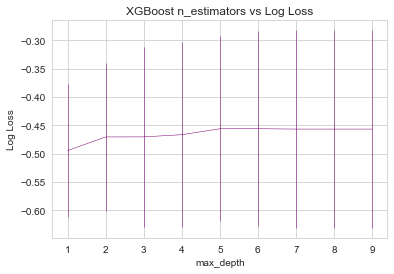

In [100]:
label_encoded_y = LabelEncoder().fit_transform(Y.values.ravel())
max_depth = range(1, 10, 1)
XGB_model = xgb.XGBClassifier(n_estimators=8,objective="binary:logistic", eval_metric='aucpr',use_label_encoder=False)

param_grid = dict(max_depth=max_depth)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(XGB_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

print("Meilleurs score : %f avec %s " % (grid_result.best_score_, grid_result.best_params_))

pyplot.errorbar(max_depth, grid_result.cv_results_['mean_test_score'], linewidth=0.5,color='#7D0374', yerr=grid_result.cv_results_['std_test_score'])
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('max_depth')
pyplot.ylabel('Log Loss')
pyplot.savefig('max_depth.png')

Meilleurs score : -0.455952 avec {'max_depth': 6, 'n_estimators': 8}


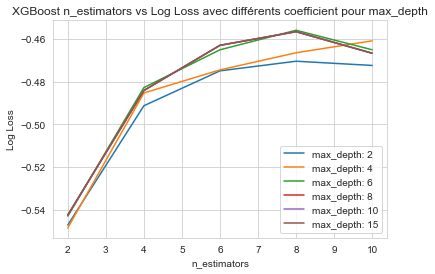

In [101]:
label_encoded_y = LabelEncoder().fit_transform(Y.values.ravel())
n_estimators = [2,4,6,8,10]
max_depth = [2,4,6,8,10,15]
XGB_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric='aucpr',use_label_encoder=False)

param_grid = dict(max_depth=max_depth,n_estimators=n_estimators)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

grid_search = GridSearchCV(XGB_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

print("Meilleurs score : %f avec %s" % (grid_result.best_score_, grid_result.best_params_))

scores = np.array(grid_result.cv_results_['mean_test_score']).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='max_depth: ' + str(value))

pyplot.title("XGBoost n_estimators vs Log Loss avec différents coefficient pour max_depth")
pyplot.xlabel('n_estimators')
pyplot.legend()
pyplot.ylabel('Log Loss')
pyplot.savefig('tree.png')

In [102]:
XGB_model = xgb.XGBClassifier(n_estimators=8,max_depth=6,objective="binary:logistic", eval_metric='aucpr',use_label_encoder=False)
xgb_ = XGB_model.fit(X_test, Y_test)
Y_preds = xgb_.predict(X_test)
print("Accuracy: %f" % (precision_score(Y_test,Y_preds)))

Accuracy: 0.893939


On voit que max_depth=8 et max_depth=10 ainsi que max_depth=15 sont très proches l'un de l'autre, et pour cause. Si nous remontons un peu plus haut, nous voyons que pour le même 'n_estimators', la perte log-vraisemblance reste quasiment constante pour tout max_depth $\geq$ 7. Donc le choix du max_depth dépend énormement du choix du nombre d'arbre à entraîner.<br>

Pourtant, dans les autres algorithmes d'aide à la décision, on retrouve souvent des arbres demandant une profondeur assez élevée pour expliquer la variable cible grâce à chaque classe, mais XGBoost lui ne se reposerais pas sur la profondeur de l'abre pour expliquer la variable cible, mais plutôt sur le nombre de weak learners sur lesquels s'entraîner.



## Observations et conclusion

D'un niveau purement algorithmique, AdaBoost est XGBoost sont deux très bon algorithmes en terme de classification, mais la complexité d'XGBoost lui permet d'avoir de meilleurs résultats, comme on peut le comparer sur la précision des deux modèles, même s'ils ne sont pas loin (0.84 pour AdaBoost et 0.89 pour XGBoost).<br>

Notre application confirme ce que la littérature générale explique de l'XGBoost, qui reste l'algorithme qui est préféré dans les modèles de boosting. Même s'il a ses inconvénients, qui sont des inconvénients communs à d'autre algorithmes de boosting, il peut aussi travailler dans des configurations qui seraient qualifiées d'extrêmement compliquées pour d'autres algorithmes comme le fait de pouvoir travailler sur un dataset contenant des valeurs manquantes, de travailler sur des jeux de données à n'importe quelles dimensions et de n'importe quelles tailles ou encore le fait qu'il soit aussi précis et simple en même temps.<br>

Dans cette partie, nous avons comparé le premier algorithme de boosting ayant été introduit en classification avec un des plus récents et nous avons vu que même s'ils ont l'air de se ressembler à première vu, les nouveaux algorithmes de boosting on l'air de gagner en compléxité et donc en "pouvoir de prédiction".